# <center> 【Kaggle】Telco Customer Churn 电信用户流失预测案例

## <font face="仿宋">第三部分导读

&emsp;&emsp;<font face="仿宋">在案例的第二部分中，我们详细介绍了常用特征转化方法，其中有些是模型训练之必须，如自然数编码、独热编码，而有些方法则是以提高数据质量为核心、在大多数时候都是作为模型优化的备选方法，如连续变量分箱、数据标准化等。当然，在此之后，我们首先尝试构建一些可解释性较强的模型来进行用户流失预测，即采用逻辑回归和决策树模型来进行预测，并同时详细介绍了两种模型在实战中的调优技巧，在最终模型训练完成后，我们也重点讨论了关于两种可解释性模型建模结果的解释方法。

&emsp;&emsp;<font face="仿宋">从理论上来说，树模型的判别能力是要强于逻辑回归的，但在上一节最后的建模结果中我们发现两个模型的建模并无显著差别，预测准确率都维持在79%-80%之间，这或许说明很多逻辑回归无法正确判别的样本决策树模型也无法判别，据此我们推测，这是一个“入门容易、精通较难”的数据集。当然，如果我们进一步尝试其他“更强”的集成学习算法，如随机森林、XGB、CatBoost等，在当前数据集上的建模结果和逻辑回归也并无太大差异，因此我们亟需通过特征工程方法进一步提升数据集质量，进而提升最终模型效果。

&emsp;&emsp;<font face="仿宋">当然，哪怕是复杂模型在当前数据集上表现出了更好的效果，采用特征工程方法提升数据质量仍是优化建模结果必不可少的部分，正如时下流行的描述那样，“数据质量决定模型上界，而建模过程只是不断逼近这个上界”，特征工程中的一系列提高数据质量的方法、无论是在工业界实践中还是各大顶级竞赛里，都已然成了最为重要的提升模型效果的手段。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gwllgk4wgqj31hr0u0wh4.jpg" alt="image-20211112170651500" style="zoom:15%;" />

&emsp;&emsp;<font face="仿宋">不过，所谓的通过特征工程方法提高数据质量，看似简单但实际操作起来却并不容易。其难点并不在于其中具体操作方法的理解，至少相比机器学习算法原理，特征工程的很多方法并不复杂，特征工程的最大难点在于配合模型与数据进行方法选择、以及各种方法的工程化部署实现。一方面，特征工程方法众多，需要根据实际情况“因地制宜”，但数据的情况千变万化，很多时候需要同时结合数据探索结论、建模人员自身经验以及对各种备选方法的熟悉程度，才能快速制定行之有效的特征工程策略；另一方面，很多特征工程方法不像机器学习算法有现成的库可以直接调用，很多方法、尤其是一些围绕当前数据集的定制方法，需要自己手动实现，而这个过程就对建模人员本身的代码编写能力及工程部署能力提出了更高的要求。总而言之，特征工程是一个实践高度相关的技术，这也是为何课程会在介绍案例的过程中同步介绍特征工程常用方法的原因。

&emsp;&emsp;<font face="仿宋">当然，从宽泛的角度来看，所有围绕数据集的数据调整工作都可以看成是特征工程的一部分，包括此前介绍的缺失值填补、数据编码、特征变换等，这些方法其实都能一定程度提升数据质量，而本节开始，我们将花费一整节的时间来讨论另一类特征工程方法：特征衍生与特征筛选。而该方法通过创建更多特征来提供更多捕捉数据规律的维度，从而提升模型效果。当然特征衍生也是目前公认的最为有效的、能够显著提升数据集质量方法。

# <center>Part 3.特征衍生与特征筛选     

&emsp;&emsp;本节开始，我们将进入到特征筛选部分内容。首先我们需要将必要的库进行导入：

In [1]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# 实用函数
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义模块
from telcoFunc import *
# 导入特征衍生模块
import features_creation as fc
from features_creation import *

# re模块相关
import inspect, re

# 其他模块
from tqdm import tqdm
import gc

&emsp;&emsp;然后执行Part 1中的数据清洗相关工作：

In [2]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
 
# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

# 连续字段转化
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

# 缺失值填补
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

# 标签值手动转化 
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [3]:
features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

&emsp;&emsp;同时，创建自然编码后的数据集以及经过时序特征衍生的数据集：

In [4]:
# 划分训练集和测试集
train, test = train_test_split(tcc, random_state=22)

X_train = train.drop(columns=[ID_col, target]).copy()
X_test = test.drop(columns=[ID_col, target]).copy()

y_train = train['Churn'].copy()
y_test = test['Churn'].copy()

X_train_seq = pd.DataFrame()
X_test_seq = pd.DataFrame()

# 年份衍生
X_train_seq['tenure_year'] = ((72 - X_train['tenure']) // 12) + 2014
X_test_seq['tenure_year'] = ((72 - X_test['tenure']) // 12) + 2014

# 月份衍生
X_train_seq['tenure_month'] = (72 - X_train['tenure']) % 12 + 1
X_test_seq['tenure_month'] = (72 - X_test['tenure']) % 12 + 1

# 季度衍生
X_train_seq['tenure_quarter'] = ((X_train_seq['tenure_month']-1) // 3) + 1
X_test_seq['tenure_quarter'] = ((X_test_seq['tenure_month']-1) // 3) + 1

# 独热编码
enc = preprocessing.OneHotEncoder()
enc.fit(X_train_seq)

seq_new = list(X_train_seq.columns)

# 创建带有列名称的独热编码之后的df
X_train_seq = pd.DataFrame(enc.transform(X_train_seq).toarray(), 
                           columns = cate_colName(enc, seq_new, drop=None))

X_test_seq = pd.DataFrame(enc.transform(X_test_seq).toarray(), 
                          columns = cate_colName(enc, seq_new, drop=None))

# 调整index
X_train_seq.index = X_train.index
X_test_seq.index = X_test.index

In [5]:
ord_enc = OrdinalEncoder()
ord_enc.fit(X_train[category_cols])

X_train_OE = pd.DataFrame(ord_enc.transform(X_train[category_cols]), columns=category_cols)
X_train_OE.index = X_train.index
X_train_OE = pd.concat([X_train_OE, X_train[numeric_cols]], axis=1)

X_test_OE = pd.DataFrame(ord_enc.transform(X_test[category_cols]), columns=category_cols)
X_test_OE.index = X_test.index
X_test_OE = pd.concat([X_test_OE, X_test[numeric_cols]], axis=1)

## <center>Ch.1 特征评估指标

- 特征筛选方法介绍

&emsp;&emsp;在完整介绍完特征衍生方法后，我们已经掌握了一整套快速构建海量特征池的方法，并且通过一些实践经验的积累，我们也能够在执行特征衍生过程中初步判断哪些方法衍生出来的特征可能有效、其他方法可能无效，也就是说我们在衍生阶段，其实就已经力求的在更短的时间内去创建更多的特征。

&emsp;&emsp;不过尽管如此，在我们创建的海量特征中，仍然并不是所有特征都是有效的，在进行简单的模型验证的过程中我们发现，有很多特征都是0值（不包含任何信息），有些特征对模型起到了适得其反的效果，而还有些特征数值重复度较高，基本就可以看成是完全相同的两个特征。而过多的无效特征将会极大程度影响模型训练效率、甚至影响模型训练结果。因此，在特征衍生结束后，我们仍然需要围绕这些特征，进行一轮特征筛选。特征筛选的目的非常明确：剔除无效特征，筛选有效特征，从而提高模型训练效率与训练结果。

&emsp;&emsp;而如何围绕这些特征进行筛选，从理论上来说，一般来说有两种思路三种方法，各类方法都不复杂，并且很多方法此前我们都接触过，此处先进行整体的统一介绍：

<center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/%E7%89%B9%E5%BE%81%E8%A1%8D%E7%94%9F.jpg" alt="特征筛选" style="zoom:50%;" />

&emsp;&emsp;当然，关于Filter、Wrapper和Embedding的划分方式非常严谨，而且也符合学术上以算法执行流程对算法进行区分的标准。但是目前来说，Filter方法确实被广泛的应用，但基于模型结果的Wrapper方法和Embedding方法，理论设计却不太符合机器学习实际建模的一般情况。

&emsp;&emsp;首先我们先来看Wrapper方法的实践层面问题。

&emsp;&emsp;就当前的机器学习应用实践来看，集成算法无疑是效果最好、应用面最广的一类算法，而集成学习的一次训练就需要训练若干个弱分类器，并且超参数调优过程需要匹配多组超参数取值进行搜索，也就是我们需要训练多个不同超参数的模型；同时，为了保证模型泛化能力，我们还需要对其进行交叉验证（当然该过程往往结合超参数搜索一起执行），此外，在很多场景下，单模效果不如模型融合效果，而模型融合则需要训练多个集成模型和一个final model，也就是复制多个上述过程。不难看出，要严格意义上执行完一次最优的模型训练，需要耗费的计算量是非常大的。反观Wrapper方法，如果我们耗费了如此大的计算量最终只是为了输出一次筛选结果，显然是不划算的，当然，在更多情况下，也是不现实的。

&emsp;&emsp;因此，如果我们要借助模型输出结果来进行特征筛选，也就是执行Wrapper过程，在目前来看，大多数情况下都会放宽建模要求（这也会导致筛选结果精度下降），并且放宽Wrapper的搜索目标。例如，我们可以在建模过程中只给出一组超参数（在原始特征上搜索出来的最有超参数），在模型训练阶段执行交叉验证，并根据交叉验证后集成学习输出的平均特征重要性来进行一定数量的特征筛选。尽管该过程看起来并不是严谨的Wrapper过程，并且也借鉴了一些Filter方法的思路，有些资料甚至将其划归为Embedding方法，但就是这样一种理论上并不完美的方法，却能够在较短的时间内搜索出较优的特征组合，当然，这也是目前实践和竞赛中更为常见的方法。

&emsp;&emsp;而另外一类方法，Embedding方法，则极大程度受限于模型原理本身。如果模型原理层面并没有给我们提供Embedding的可能，我们是无法通过参数或者建模流程调整，自行进行Embedding的。截至目前，在Scikit-Learn中，能够比较好的能够执行Embedding过程的也只有带正则项（尤其是L1正则项）的线性回归和逻辑回归，但线性方程又无法容忍（处理）过高维度的特征矩阵，这使得其无法在海量特征中进行特征筛选，只能先借助其他过程进行预筛选或者PCA降维（这或许是一种更好的方法，线性方程始终对共线性敏感），然后再带入Embedding过程。此外，由于线性方程本身模型效果有限，在很多情况下并不是我们首选的模型，因此这也限制了Embedding方法的发挥。

&emsp;&emsp;尽管Wrapper和Embedding的理论和实践略有脱节，但在长期的实践过程中，大家还是寻找到了很多高效的特征筛选方法，包括上述介绍的Wrapper改进方法、特征重要性筛选法，以及目前竞赛中经常被用到的null importance方法。而课程将以实战为主，并不会介绍理论严谨但实践困难的诸多方法，而是根据目前的实践情况，重点介绍高效有效的筛选方法。因此，课上也将舍弃Filter、Wrapper、Embedding的划分方式，而是按照特征评估指标和特征筛选过程两阶段来进行介绍，在大多数实践情况下，特征筛选的过程都是混合多种指标和过程的。

&emsp;&emsp;本节我们将首先重点介绍关于特征有效性的评估指标。关于特征有效性的评估指标，整体来看可以分为三类，分别是特征信息量包含指标、特征和标签关联度指标以及模型重要性指标。三类评估指标层层递进，我们也将逐个对其进行介绍。

## 一、信息包含量指标

&emsp;&emsp;首先，最为通用、且往往用于特征筛选的第一步的特征有效性评估指标，就是特征的信息包含量指标。很明显，且不论所包含信息是否有效，如果特征本身包含信息有限甚至是根本就不包含任何有效信息，则需要在特征筛选的第一个环节就被快速的剔除，以提升后续进行特征有效性识别与筛选的效率。

&emsp;&emsp;而对于特征所包含信息量的识别也并不复杂，我们可以通过两个指标的计算来进行判断，其一是特征的缺失值所占比例，其二是单变量的方差。对于某个特征来说，如果缺失值占比过大（如超过90%），除非从业务角度判断可以通过标记法进行填补，否则可以视作特征信息大范围缺失，是没有进一步分析必要的，可以直接剔除；其次，对于不包含缺失值的字段，我们也可以通过方差对其包含信息量进行识别，一般来说方差越小、特征包含的信息量就越少，极端情况下，方差取值为0时，该特征所有取值都一样，也就相当于不包含任何有效信息，是需要被快速识别和剔除的。

### 1.缺失值比例计算与特征筛选

&emsp;&emsp;首先我们来看单变量缺失值比例计算方法与特征剔除过程。该过程并不复杂，唯一需要注意的是，从流程上来说，我们在数据预处理阶段（也就是特征衍生之前）就会完成缺失值的识别和填补工作，因此到了特征筛选阶段出现的缺失值，极有可能是特征衍生过程中生成的缺失值，该部分缺失值往往也不具备任何业务特殊性（不是某类特殊样本的某种标记），因此是可以直接考虑提出那些缺失比例较高的特征的。

&emsp;&emsp;缺失值比例计算与筛选可以通过如下方式实现。需要注意的是，在特征筛选环节，我们仍然需要在训练集上进行训练，然后再测试集上进行测试，并且如果存在缺失值但没达到剔除的标准，则对其进行固定值填补：

In [6]:
def MissingValueThreshold(X_train_temp, X_test_temp, threshold = 0.9, fn = 0):
    """
    根据比例删除缺失值比例较高的特征
    同时将其他缺失值统一填补为fn的值
    
    :param X_train_temp: 训练集特征
    :param X_test_temp: 测试集特征
    :param threshold: 缺失值比例阈值
    :param fn: 其他缺失值填补数值
    
    :return：剔除指定特征后的X_train_temp和X_test_temp
    """
    for col in X_train_temp:
        if X_train_temp[col].isnull().sum() / X_train_temp.shape[0] >= threshold:
            del X_train_temp[col]
            del X_test_temp[col]
        else:
            X_train_temp[col] = X_train_temp[col].fillna(fn)
            X_test_temp[col] = X_test_temp[col].fillna(fn)
    return X_train_temp, X_test_temp

In [7]:
df_train = pd.DataFrame({'x1':[1, np.nan, np.nan], 'x2':[1, 2, np.nan], 'X3':[1, 2, 3]})

In [8]:
df_test = df_train.copy()

In [9]:
df_test

,x1,x2,X3
0,1.0,1.0,1
1,NaN,2.0,2
2,NaN,NaN,3


In [10]:
df_test.isnull().sum()

x1    2
x2    1
X3    0
dtype: int64

In [11]:
X_train, X_test = MissingValueThreshold(df_train, df_test, threshold = 0.5)
X_test

,x2,X3
0,1.0,1
1,2.0,2
2,0.0,3


### 2.单变量方差与特征筛选

&emsp;&emsp;接下来我们进一步考虑单变量方差的计算过程与特征筛选过程，该过程要求先单独对数据集的每一列进行方差计算，然后根据给出的阈值剔除那些方差没达到阈值的列。该过程可以借助sklearn中的VarianceThreshold评估器快速实现。

In [12]:
from sklearn.feature_selection import VarianceThreshold

- 样本方差与总体方差

&emsp;&emsp;首先我们简单回顾下方差计算公式。对于方差计算来说，其实有两种计算方式，分别是样本方差和总体方差。对于样本方差来说，就是每个样本与均值的差值平方和除以样本总数的计算结果：

$$Var[X] = \frac{\sum^{n}_{i=1}(x_i-\bar x)^2}{n}$$

其中X表示随机变量，$x_i$表示某次观测值，$\bar x$表示均值，n表示样本总数。

&emsp;&emsp;而如果是计算总体方差，由于此间涉及到通过样本对总体进行推断的过程，因此自由度需要减1，实际计算过程如下所示：

$$Var[X] = \frac{\sum^{n}_{i=1}(x_i-\bar x)^2}{n-1}$$

即在分母位置上-1。

- numpy中的方差计算

&emsp;&emsp;而在NumPy中，默认执行的是总体方差计算。我们可以通过如下方式进行验算：

In [13]:
df_temp = pd.DataFrame({'x1':[1, 2, 4], 'x2':[1, 2, 1], 'x3':[1, 1, 1]})
df_temp

,x1,x2,x3
0,1,1,1
1,2,2,1
2,4,1,1


In [14]:
df_temp.var()

x1    2.333333
x2    0.333333
x3    0.000000
dtype: float64

In [15]:
np.power((df_temp['x1'] - df_temp['x1'].mean()), 2).sum() / 2

2.333333333333333

而若要计算单样本方差，则需要输入参数ddof=0：

In [16]:
df_temp.var(ddof=0)

x1    1.555556
x2    0.222222
x3    0.000000
dtype: float64

In [17]:
np.power((df_temp['x1'] - df_temp['x1'].mean()), 2).sum() / 3

1.5555555555555554

In [18]:
# 而默认情况下，相当于自由度-1
df_temp.var(ddof=1)

x1    2.333333
x2    0.333333
x3    0.000000
dtype: float64

- VarianceThreshold评估器

&emsp;&emsp;需要注意的是，对于sklearn中VarianceThreshold评估器则默认进行样本方差计算，且不能修改，也就是说VarianceThreshold是按照如下方式进行的方差计算及筛选：

$$Var[X] = \frac{\sum^{n}_{i=1}(x_i-\bar x)^2}{n}$$

In [19]:
VarianceThreshold?

Init signature: VarianceThreshold(threshold=0.0)
Docstring:     
Feature selector that removes all low-variance features.

This feature selection algorithm looks only at the features (X), not the
desired outputs (y), and can thus be used for unsupervised learning.

Read more in the :ref:`User Guide <variance_threshold>`.

Parameters
----------
threshold : float, default=0
    Features with a training-set variance lower than this threshold will
    be removed. The default is to keep all features with non-zero variance,
    i.e. remove the features that have the same value in all samples.

Attributes
----------
variances_ : array, shape (n_features,)
    Variances of individual features.

n_features_in_ : int
    Number of features seen during :term:`fit`.

    .. versionadded:: 0.24

feature_names_in_ : ndarray of shape (`n_features_in_`,)
    Names of features seen during :term:`fit`. Defined only when `X`
    has feature names that are all strings.

    .. versionadded:: 1.0

See Also

VarianceThreshold评估器有且只有一个参数，即方差阈值，需要注意的是，只有某列的方差大于该阈值，才能被保留，而小于或等于该阈值的方差对应的列都会被剔除：

In [20]:
# 实例化评估器
sel = VarianceThreshold(threshold=1.5)

In [21]:
# 训练评估器，对数据集进行修改
sel.fit_transform(df_temp)

array([[1],
       [2],
       [4]], dtype=int64)

需要注意的是，由于VarianceThreshold是执行的样本方差计算，因此若将阈值设置为1.6，则无法筛选出任何特征：

In [22]:
# sel = VarianceThreshold(threshold=1.6)
# sel.fit_transform(df_temp)

In [23]:
df_temp.var(ddof=0)

x1    1.555556
x2    0.222222
x3    0.000000
dtype: float64

因此，若要先预估样本基本方差分布再设置阈值，则需要借助var(ddof=0)过程。当然，在大多数情况下，由于少量信息也可能对建模造成重大影响（如恰好能够识别异常值），所以我们往往只剔除那些方差为0的特征，也就是删除取值完全相同的特征，此时采用VarianceThreshold默认参数即可：

In [24]:
df_temp

,x1,x2,x3
0,1,1,1
1,2,2,1
2,4,1,1


In [25]:
sel = VarianceThreshold()
sel.fit_transform(df_temp)

array([[1, 1],
       [2, 2],
       [4, 1]], dtype=int64)

此外需要注意的是，由于我们往往希望保留剔出特征后的列名称，而上述评估器最终输出结果是一个array，我们需要借助VarianceThreshold评估器的variances_属性，来查看每一列的方差计算结果，并据此推算剔除和保留的列，并最终给保留列赋予列名称：

In [26]:
sel.variances_

array([1.55555556, 0.22222222, 0.        ])

In [27]:
sel.variances_ == 0

array([False, False,  True])

In [28]:
df_temp.columns

Index(['x1', 'x2', 'x3'], dtype='object')

In [29]:
df_temp.columns[sel.variances_ != 0]

Index(['x1', 'x2'], dtype='object')

In [30]:
df_temp[df_temp.columns[sel.variances_ != 0]]

,x1,x2
0,1,1
1,2,2
2,4,1


- VarianceThreshold阈值选取

&emsp;&emsp;需要注意的是，特征的方差会显著的受到特征取值大小的影响，即某特征本身取值较大，方差计算结果也越大，例如某列取值放大10倍，则方差会放大100倍：

In [31]:
(df_temp['x1']).var(ddof=0)

1.5555555555555554

In [32]:
(df_temp['x1'] * 10).var(ddof=0)

155.55555555555557

因此，很多时候对于连续变量来说，除非我们很明确各连续特征的量纲一致，否则设置阈值筛选特征的意义不大，更多的时候我们是使用VarianceThreshold默认参数剔除哪些方差为0的连续特征。

&emsp;&emsp;当然，有同学肯定会觉得，既然取值大小会影响方差计算结果，那能不能通过标准化消除这种影响呢？答案是肯定不行。如果是Z-Score标准化，则会将特征转化为均值为0、标准差为1的特征，此时除了原本方差为0的特征，其他所有特征的方差都会转化为1：

In [33]:
df_temp1 = pd.DataFrame(preprocessing.scale(df_temp), columns=df_temp.columns)
df_temp1

,x1,x2,x3
0,-1.069045,-0.707107,0.0
1,-0.267261,1.414214,0.0
2,1.336306,-0.707107,0.0


In [34]:
df_temp.var(ddof=0)

x1    1.555556
x2    0.222222
x3    0.000000
dtype: float64

In [35]:
df_temp1.var(ddof=0)

x1    1.0
x2    1.0
x3    0.0
dtype: float64

而如果0-1标准化，则会有可能打乱原始方差的大小顺序：

In [36]:
df_temp1 = pd.DataFrame(preprocessing.minmax_scale(df_temp), columns=df_temp.columns)
df_temp1

,x1,x2,x3
0,0.000000,0.0,0.0
1,0.333333,1.0,0.0
2,1.000000,0.0,0.0


In [37]:
df_temp1.var(ddof=0)

x1    0.172840
x2    0.222222
x3    0.000000
dtype: float64

因此，切忌先对连续变量进行标准化再进行方差筛选。

- VarianceThreshold作用于离散变量

&emsp;&emsp;此外，对于上述介绍的样本方差计算公式和总体方差计算公式，其实都是针对于连续变量进行的计算，如果特征是二分类离散特征，在假设其分布为伯努利分布的情况下，我们可以通过两类样本取值的占比来计算其方差：

$$\mathrm{Var}[X] = p(1 - p)$$

该公式中，由于p和1-p是对应关系，因此无论是指代0类样本占比还是指代1类样本占比皆可。

In [38]:
df_temp = pd.DataFrame({'x1':[0, 0, 1, 1, 1, 0], 'x2':[1, 1, 1, 1, 0, 0], 'x3':[0, 0, 0, 0, 1, 0], 'x4':[0, 0, 0, 0, 0, 0]})
df_temp

,x1,x2,x3,x4
0,0,1,0,0
1,0,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,0,1,0
5,0,0,0,0


In [39]:
df_temp['x2']

0    1
1    1
2    1
3    1
4    0
5    0
Name: x2, dtype: int64

In [40]:
2/6 * (1-2/6)

0.22222222222222224

对应的，如果按照该计算方法，某列的少数类样本比例高于1/3，则最终方差也要大于0.22：

In [41]:
df_temp['x1']

0    0
1    0
2    1
3    1
4    1
5    0
Name: x1, dtype: int64

In [42]:
# x2列方差
1/2 * (1-1/2)

0.25

而反之，如果少数类样本比例少于1/3，则该列方差也要小于0.22：

In [43]:
df_temp['x3']

0    0
1    0
2    0
3    0
4    1
5    0
Name: x3, dtype: int64

In [44]:
# x2列方差
1/6 * (1-1/6)

0.1388888888888889

据此，我们可以通过方差来剔除正负样本比例过于偏态的特征，及剔除那些少数类样本过少或者多数类样本过多的列，无论哪种情况，此时该列的取值分布会趋于一致，方差较小，且对应的包含有效信息也较少。需要注意的是，不同类别的样本占比也是我们判断离散特征是否需要被剔除的普遍依据。例如如果我们想剔除少数类样本占比少于30%的特征，则可以进行如下计算：

In [45]:
3/10 * (1-3/10)

0.21

In [46]:
df_temp

,x1,x2,x3,x4
0,0,1,0,0
1,0,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,0,1,0
5,0,0,0,0


In [47]:
sel = VarianceThreshold(threshold=0.21)
sel.fit_transform(df_temp)

array([[0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [0, 0]], dtype=int64)

In [48]:
sel.variances_

array([0.25      , 0.22222222, 0.13888889, 0.        ])

In [49]:
# 查看保留列的df
df_temp[df_temp.columns[sel.variances_ > 0.21]]

,x1,x2
0,0,1
1,0,1
2,1,1
3,1,1
4,1,0
5,0,0


当然，在默认情况下，无论是连续变量还是离散变量，VarianceThreshold都将剔除那些取值全部一样的列：

In [50]:
sel = VarianceThreshold()
sel.fit_transform(df_temp)

array([[0, 1, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       [1, 0, 1],
       [0, 0, 0]], dtype=int64)

- 总结VarianceThreshold使用方法

【必要流程】        
&emsp;&emsp;选择VarianceThreshold的默认参数，剔除那些数据一致的特征（无论是离散变量还是连续变量）；      
【可选流程】      
&emsp;&emsp;如果需要进一步剔除那些方差不为0，但取值较小的列，则可以通过修改方差阈值的方法，利用VarianceThreshold剔除那些方差不满足阈值的列。不过这里对于连续变量和离散变量的考虑是不同的，对于连续变量来说，我们可以通过var(ddof=0)查看每一列的方差，在对连续特征方差分布有一定的了解后，设置阈值并剔除方差较小的列。这里需要注意的是，方差大小也会受到特征取值大小影响，但连续变量的标准化并不能达到消除量纲影响、同时又保留方差能够衡量特征信息量的功能，因此大多数时候我们只会考虑利用VarianceThreshold剔除那些方差为0的连续变量；而对于二分类离散变量来说，我们会假设其满足伯努利分布，然后通过每一类样本的占比与方差之间的映射关系，通过少数类占比是否少于某一比例（或者多数类样本是否多于某一比例）来判断是否需要剔除某列。当然，如果是对于三分类及以上的离散变量，我们可以将其视作连续变量处理。

## 二、特征和标签关联度指标

- 判断特征包含信息“是否有用”

&emsp;&emsp;接下来，我们进一步介绍特征和标签关联度指标。第一部分的信息包含量指标重点衡量的是特征包含的信息量大小，而本部分开始介绍的指标，则是用于衡量特征所包含的这些信息是否有用。

&emsp;&emsp;而要判断特征所包含的信息是否有用，一般来说可以通过两类方法进行衡量，其一是通过一些“先验”的统计量的计算，在实际带入模型之前，先预判该特征能否帮助模型更好的进行预测，例如此前介绍的相关系数指标。该类指标都是试图分析特征和标签是否具备某些同步变化或者相同分布的特性，来达到预判的目的，因此这类指标也被称为特征与标签关联度指标；此外，还有一类方法，则更加简单粗暴，特征是否有效其实归根结底还是需要看最终的建模结果，如果在实际建模过程中某特征确实做出了重大贡献（例如在树模型中提供了非常多的可对标签进行有效分类的点），则认为该特征是重要特征，不难看出，该类方法的实现需要将特征带入到模型中进行计算，因此该类方法也被称为模型重要性指标，典型的如树模型的features_importance。

&emsp;&emsp;而对比两类方法我们不难发现，相比之下，特征和标签的关联度指标所需计算量较少且非常便于分布式计算，而模型重要性指标则是以终为始，同时也需要耗费更大量的计算量。当然两类方法都是非常重要的方法，在实际特征筛选的过程中，都有各自的使用场景。接下来我们首先介绍特征和标签关联度指标。

- 特征和标签关联度指标的“先验”过程

&emsp;&emsp;首先需要注意的是，对于大多数特征和标签的关联指标，由于是一个“先验”的过程，因此大多的指标在计算和使用的过程中都会涉及较强的统计背景，主要是假设检验相关知识。这里我们会更加侧重介绍方法的使用，而并不会深入介绍相关统计理论，主要原因在于两套理论有较大差异，且在机器学习建模流程中，借助关联度指标进行特征筛选也往往是初筛，并不需要精准的检验结果作为依据，例如我们并不会以p值作为特征是否可用的依据（并不只使用那些显著相关的变量），而是“简单粗暴”的划定一个范围（例如挑选相关性前100的特征）；其次，在后续的建模的环节，我们也是使用机器学习模型而非统计学模型，这也将是的基于假设检验的精准筛选意义不大。

### 1.借助sklearn进行特征评估及筛选

- 指标计算与特征筛选

&emsp;&emsp;对于借助关联指标进行筛选的过程，我们可以借助sklearn中相关功能快速实现，这里会涉及到函数和评估器的配套使用，我们同时需要调用（指标）计算函数和特征筛选评估器。这里以挑选相关系数最大的特征为例进行说明，假设我们需要围绕原始数据集挑选和标签最相关的10个特征，则可以通过如下代码实现：

In [51]:
# 经过自然数编码的训练集数据
X_train_OE.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
4067,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,68,79.60,5515.80
3306,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,3,80.00,241.30
3391,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,19.00,73.45
3249,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,10,55.55,551.30
2674,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,20.05,91.45


In [52]:
# 计算相关系数
df_temp = pd.concat([X_train_OE, y_train], axis=1)
df_corr = df_temp.corr()['Churn']
df_corr

gender             -0.018605
SeniorCitizen       0.140164
Partner            -0.159577
Dependents         -0.152544
PhoneService       -0.002501
MultipleLines       0.031559
InternetService    -0.054444
OnlineSecurity     -0.307484
OnlineBackup       -0.197237
DeviceProtection   -0.191164
TechSupport        -0.288867
StreamingTV        -0.039879
StreamingMovies    -0.050142
Contract           -0.394464
PaperlessBilling    0.186661
PaymentMethod       0.116375
tenure             -0.357263
MonthlyCharges      0.181830
TotalCharges       -0.210238
Churn               1.000000
Name: Churn, dtype: float64

然后挑选绝对值最大的10个特征。当然，该过程我们也可以借助sklearn中相关功能实现，首先sklearn中的相关系数计算函数为r_regression：

In [53]:
from sklearn.feature_selection import r_regression

> 注，该函数为1.0版本新增函数，若导入过程显示未找到该模块，则需要更新sklearn，可以按照如下方式进行更新：      
> <center>conda install scikit-learn=1.0.2        

In [54]:
r_regression(X_train_OE, y_train)

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

然后，我们可以按照计算绝对值、取绝对值最大的10个特征的流程进行计算。当然，在sklearn中，提供了一种更为简便、并且可以套用在这些计算函数外层的评估器，例如，如果我们希望依据r_regression函数输出的结果，挑选相关性最强的10个特征，可以将r_regression函数SelectKBest评估器中，然后进行筛选：

In [55]:
from sklearn.feature_selection import SelectKBest

In [56]:
SelectKBest?

Init signature: SelectKBest(score_func=<function f_classif at 0x000001D4349A6E50>, *, k=10)
Docstring:     
Select features according to the k highest scores.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
score_func : callable, default=f_classif
    Function taking two arrays X and y, and returning a pair of arrays
    (scores, pvalues) or a single array with scores.
    Default is f_classif (see below "See Also"). The default function only
    works with classification tasks.

    .. versionadded:: 0.18

k : int or "all", default=10
    Number of top features to select.
    The "all" option bypasses selection, for use in a parameter search.

Attributes
----------
scores_ : array-like of shape (n_features,)
    Scores of features.

pvalues_ : array-like of shape (n_features,)
    p-values of feature scores, None if `score_func` returned only scores.

n_features_in_ : int
    Number of features seen during :term:`fit`.

    .. versionadded:: 

In [57]:
KB = SelectKBest(r_regression, k=10)

In [58]:
X_new = KB.fit_transform(X_train_OE, y_train)
X_new.shape

(5282, 10)

In [59]:
X_new[:5]

array([[ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  2.  ,  2.  ,  1.  ,  0.  ,
        79.6 ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  2.  ,
        80.  ],
       [ 1.  ,  0.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        19.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  3.  ,
        55.55],
       [ 0.  ,  1.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        20.05]])

然后我们可以通过评估器的如下属性查看更多计算过程中的细节信息：

In [60]:
# 输入的所有特征
KB.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [61]:
# 每个特征相关系数
KB.scores_

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

In [62]:
# 每个特征的p值，目前返回结果为None
KB.pvalues_

In [63]:
KB.k

10

此处X_new就是我们筛选出的、根据r_regression计算得分最高的10个特征。方法使用过程并不复杂，而sklearn中的这种评分函数和筛选评估器分开的设计，也能很好的保证后续使用的灵活性，例如如果我们不想以r_regression作为评分函数，则可在筛选评估器的参数中直接修改，而如果我们不是筛选KBest（K和最好的结果），而是按照百分比进行筛选，则可以更换筛选评估器（SelectPercentile，后续会介绍）。并且筛选过程封装成评估器，也便于我们实现在训练集上进行训练、在测试集上进行测试的过程。

&emsp;&emsp;但对于上述过程，有两点需要注意，首先，SelectKBest只会根据输入函数的评分按照由高到低进行筛选，因此此处输出的特征只是相关系数最大的10个特征，并不是相关系数绝对值最大的10个特征；其次，返回结果的特征排序其实是原始特征在剔除了那些评分未进前10的特征之后的特征，并不是按照评分由高到低排名的前10个特征。我们先看在使用SelectKBest评估器时如何获取列名称，再来看如何修正相关系数评估指标。

- 列名称获取

&emsp;&emsp;该操作的基本思路也较为简单，首先我们可以根据feature_names_in_和scores_属性确定每个特征的评分，然后找出被选入特征评分的最小值，然后据此进行筛选。当然，该流程不仅适用于r_regression评分的情况，也适用于其他评分函数（后续会介绍）的情况。

In [64]:
sorted(KB.scores_, reverse=True)[:10]

[0.18666114409941312,
 0.1818296585911835,
 0.1401638312930749,
 0.11637491358418606,
 0.031559498813656606,
 -0.0025008080096673483,
 -0.018605127155478008,
 -0.03987905886854042,
 -0.05014175688732029,
 -0.05444390781636287]

In [65]:
threshold = sorted(KB.scores_, reverse=True)[9]
threshold

-0.05444390781636287

In [66]:
KB.scores_

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

In [67]:
KB.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [68]:
for i in zip(KB.scores_, KB.feature_names_in_):
    print(i)

(-0.018605127155478008, 'gender')
(0.1401638312930749, 'SeniorCitizen')
(-0.1595774481386036, 'Partner')
(-0.15254381815342433, 'Dependents')
(-0.0025008080096673483, 'PhoneService')
(0.031559498813656606, 'MultipleLines')
(-0.05444390781636287, 'InternetService')
(-0.30748404756970066, 'OnlineSecurity')
(-0.19723667022421654, 'OnlineBackup')
(-0.19116379106171, 'DeviceProtection')
(-0.2888665015816091, 'TechSupport')
(-0.03987905886854042, 'StreamingTV')
(-0.05014175688732029, 'StreamingMovies')
(-0.39446444163483935, 'Contract')
(0.18666114409941312, 'PaperlessBilling')
(0.11637491358418606, 'PaymentMethod')
(-0.3572633742522449, 'tenure')
(0.1818296585911835, 'MonthlyCharges')
(-0.21023844378550435, 'TotalCharges')


In [69]:
col_names = []

for i in zip(KB.scores_, KB.feature_names_in_):
    if i[0] >= threshold:
        col_names.append(i[1])

In [70]:
col_names

['gender',
 'SeniorCitizen',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges']

验证提取列是否正确：

In [71]:
X_train_OE[col_names].head()

,gender,SeniorCitizen,PhoneService,MultipleLines,InternetService,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges
4067,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,79.60
3306,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,80.00
3391,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,19.00
3249,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,55.55
2674,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,20.05


In [72]:
X_new[:5]

array([[ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  2.  ,  2.  ,  1.  ,  0.  ,
        79.6 ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  2.  ,
        80.  ],
       [ 1.  ,  0.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        19.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  3.  ,
        55.55],
       [ 0.  ,  1.  ,  1.  ,  0.  ,  2.  ,  1.  ,  1.  ,  0.  ,  3.  ,
        20.05]])

In [73]:
(X_train_OE[col_names] != X_new).sum()

gender              0
SeniorCitizen       0
PhoneService        0
MultipleLines       0
InternetService     0
StreamingTV         0
StreamingMovies     0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
dtype: int64

据此，我们可以将筛选后的array封装成一个dataframe：

In [74]:
X_train_new = pd.DataFrame(X_new, columns=col_names)
X_train_new.head(5)

,gender,SeniorCitizen,PhoneService,MultipleLines,InternetService,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,79.60
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,80.00
2,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,19.00
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,55.55
4,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,20.05


由于后续我们将经常使用sklearn中相关评估器进行特征筛选，因此我们这里可以将筛选后列名称的提取过程封装为一个函数：

In [75]:
def SelectName(KB):
    """
    根据特征筛选评估器进行列名称输出函数
    
    :param KB: 训练后的BestK特征筛选评估器
    
    :return：保留特征的列名称
    """
    threshold = sorted(KB.scores_, reverse=True)[KB.k - 1]
    
    col_names = []

    for score, col in zip(KB.scores_, KB.feature_names_in_):
        if score >= threshold:
            col_names.append(col)
            
    return col_names

测试函数性能：

In [76]:
SelectName(KB)

['gender',
 'SeniorCitizen',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges']

> 在后续介绍了更多特征筛选评估器后，还将继续修改丰富该函数

> 此外需要注意，在sklearn的1.0版本中加入了get_feature_names_out属性，也能够实现SelectName函数的相同功能，输出筛选后的列名称。

- f_regression评分函数

&emsp;&emsp;接下来继续解决此前提出的另一个问题，那就是BestK过程只能提取那些评分最高的特征，但如果是计算相关系数，其实正负相关性都是可以使用的，也就是说我们更希望这个过程是一个先计算绝对值、再进行特征筛选的过程。此时如果要实现该功能，则需要借助sklearn中的另一个评分函数：f_regression

In [77]:
from sklearn.feature_selection import f_regression
f_regression?

Signature: f_regression(X, y, *, center=True)
Docstring:
Univariate linear regression tests returning F-statistic and p-values.

Quick linear model for testing the effect of a single regressor,
sequentially for many regressors.

This is done in 2 steps:

1. The cross correlation between each regressor and the target is computed,
   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
   std(y)) using r_regression function.
2. It is converted to an F score and then to a p-value.

:func:`f_regression` is derived from :func:`r_regression` and will rank
features in the same order if all the features are positively correlated
with the target.

Note however that contrary to :func:`f_regression`, :func:`r_regression`
values lie in [-1, 1] and can thus be negative. :func:`f_regression` is
therefore recommended as a feature selection criterion to identify
potentially predictive feature for a downstream classifier, irrespective of
the sign of the association with the target vari

该函数计算的是特征和标签之间的f评分（f-Score），尽管f-Score这一叫法并不常见，但其实就是进行的F检验，通过查看sklearn该部分源码，我们能够看到sklearn中的f评分是按照如下方式进行的计算：

<center><img src="https://s2.loli.net/2022/03/24/koawm45Ltqp8QB7.png" alt="image-20220324152933797" style="zoom:50%;" />

此处关于F检验的具体含义我们稍后会在补充假设检验相关理论时介绍，从使用角度来说，f_regression的本质就是评估两列的相关性，如果考虑到评分的数值结果，则从数值大小顺序上来说，就相当于相关系数取绝对值后排序结果：

In [78]:
# 相关系数取绝对值后降序排列
np.abs(df_corr).sort_values(ascending=False)

Churn               1.000000
Contract            0.394464
tenure              0.357263
OnlineSecurity      0.307484
TechSupport         0.288867
TotalCharges        0.210238
OnlineBackup        0.197237
DeviceProtection    0.191164
PaperlessBilling    0.186661
MonthlyCharges      0.181830
Partner             0.159577
Dependents          0.152544
SeniorCitizen       0.140164
PaymentMethod       0.116375
InternetService     0.054444
StreamingMovies     0.050142
StreamingTV         0.039879
MultipleLines       0.031559
gender              0.018605
PhoneService        0.002501
Name: Churn, dtype: float64

In [79]:
r_regression(X_train_OE, y_train)

array([-0.01860513,  0.14016383, -0.15957745, -0.15254382, -0.00250081,
        0.0315595 , -0.05444391, -0.30748405, -0.19723667, -0.19116379,
       -0.2888665 , -0.03987906, -0.05014176, -0.39446444,  0.18666114,
        0.11637491, -0.35726337,  0.18182966, -0.21023844])

In [80]:
f_regression(X_train_OE, y_train)

(array([1.82830886e+00, 1.05809064e+02, 1.37968358e+02, 1.25790676e+02,
        3.30215414e-02, 5.26413346e+00, 1.56971831e+01, 5.51331645e+02,
        2.13718300e+02, 2.00268721e+02, 4.80694566e+02, 8.41036703e+00,
        1.33084137e+01, 9.72976942e+02, 1.90609054e+02, 7.24894091e+01,
        7.72527122e+02, 1.80536389e+02, 2.44169411e+02]),
 array([1.76385336e-001, 1.38355399e-024, 1.81898481e-031, 7.22810806e-029,
        8.55810777e-001, 2.18083235e-002, 7.53147576e-005, 4.77214318e-116,
        1.77787847e-047, 1.18499278e-044, 4.77485174e-102, 3.74626992e-003,
        2.66766949e-004, 3.37661304e-196, 1.27838178e-042, 2.16345286e-017,
        8.46456399e-159, 1.70182240e-040, 7.67071015e-054]))

此处能看到f_regression返回了两个结果，其中第一个array是F-Score，第二个array是p值。关于p值的概念稍后会进行介绍，此处先讨论F-Score计算结果所表现出的一些特性。

In [81]:
df_corr1 = pd.Series(f_regression(X_train_OE, y_train)[0], index=list(X_train_OE.columns))

In [82]:
df_corr1.sort_values(ascending=False)

Contract            972.976942
tenure              772.527122
OnlineSecurity      551.331645
TechSupport         480.694566
TotalCharges        244.169411
OnlineBackup        213.718300
DeviceProtection    200.268721
PaperlessBilling    190.609054
MonthlyCharges      180.536389
Partner             137.968358
Dependents          125.790676
SeniorCitizen       105.809064
PaymentMethod        72.489409
InternetService      15.697183
StreamingMovies      13.308414
StreamingTV           8.410367
MultipleLines         5.264133
gender                1.828309
PhoneService          0.033022
dtype: float64

In [83]:
df_corr1.sort_values(ascending=False).index == np.abs(df_corr).sort_values(ascending=False)[1:].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

能够发现，基于F-Score的排序结果和基于相关系数绝对值的排序结果一致。那么接下来，我们就可以借助f_regression进行最相关的特征的筛选：

In [84]:
KB = SelectKBest(f_regression, k=10)

In [85]:
X_new = KB.fit_transform(X_train_OE, y_train)
X_new.shape

(5282, 10)

此时筛选出来的特征如下：

In [86]:
SelectName(KB)

['Partner',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [87]:
np.abs(df_corr).sort_values(ascending=False)[1:11]

Contract            0.394464
tenure              0.357263
OnlineSecurity      0.307484
TechSupport         0.288867
TotalCharges        0.210238
OnlineBackup        0.197237
DeviceProtection    0.191164
PaperlessBilling    0.186661
MonthlyCharges      0.181830
Partner             0.159577
Name: Churn, dtype: float64

- SelectPercentile按比例筛选特征

&emsp;&emsp;当然，对于筛选评估器来说，除了可以筛选评分最高的k个特征，还可以按照比例进行筛选。此时就需要用到SelectPercentile评估器了：

In [88]:
from sklearn.feature_selection import SelectPercentile

In [89]:
SelectPercentile?

Init signature:
SelectPercentile(
    score_func=<function f_classif at 0x000001D4349A6E50>,
    *,
    percentile=10,
)
Docstring:     
Select features according to a percentile of the highest scores.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
score_func : callable, default=f_classif
    Function taking two arrays X and y, and returning a pair of arrays
    (scores, pvalues) or a single array with scores.
    Default is f_classif (see below "See Also"). The default function only
    works with classification tasks.

    .. versionadded:: 0.18

percentile : int, default=10
    Percent of features to keep.

Attributes
----------
scores_ : array-like of shape (n_features,)
    Scores of features.

pvalues_ : array-like of shape (n_features,)
    p-values of feature scores, None if `score_func` returned only scores.

n_features_in_ : int
    Number of features seen during :term:`fit`.

    .. versionadded:: 0.24

feature_names_in_ : ndarray 

该评估器除了参数和SelectKBest略有差异外，其他没有任何区别，例如此处考虑筛选评分前30%的特征：

In [90]:
SP = SelectPercentile(f_regression, percentile=30)
SP.fit(X_train_OE, y_train)

SelectPercentile(percentile=30,
                 score_func=<function f_regression at 0x000001D4359D20D0>)

In [91]:
SP.scores_

array([1.82830886e+00, 1.05809064e+02, 1.37968358e+02, 1.25790676e+02,
       3.30215414e-02, 5.26413346e+00, 1.56971831e+01, 5.51331645e+02,
       2.13718300e+02, 2.00268721e+02, 4.80694566e+02, 8.41036703e+00,
       1.33084137e+01, 9.72976942e+02, 1.90609054e+02, 7.24894091e+01,
       7.72527122e+02, 1.80536389e+02, 2.44169411e+02])

In [92]:
SP.pvalues_

array([1.76385336e-001, 1.38355399e-024, 1.81898481e-031, 7.22810806e-029,
       8.55810777e-001, 2.18083235e-002, 7.53147576e-005, 4.77214318e-116,
       1.77787847e-047, 1.18499278e-044, 4.77485174e-102, 3.74626992e-003,
       2.66766949e-004, 3.37661304e-196, 1.27838178e-042, 2.16345286e-017,
       8.46456399e-159, 1.70182240e-040, 7.67071015e-054])

In [93]:
SP.n_features_in_

19

In [94]:
SP.percentile

30

In [95]:
SP.transform(X_train_OE)

array([[2.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 6.8000e+01,
        5.5158e+03],
       [0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        2.4130e+02],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00,
        7.3450e+01],
       ...,
       [0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 2.8000e+01,
        3.1525e+03],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.5000e+01,
        3.3595e+02],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 6.8000e+01,
        1.6643e+03]])

In [96]:
SP.transform(X_train_OE).shape

(5282, 6)

能够看出此时筛选出了前6个特征。同样，我们希望能够自动化的创建这些特征的名称，因此我们需要简单修改SelectName函数，使其能够从SelectPercentile评估器中也能够自动创建筛选后的列的名称。这里需要注意的一点是，SelectPercentile最终输出的筛选特征的个数，尤其是当比例和原始特征数量无法整除时输出的特征数量。通过观察源码我们发现，SelectPercentile最终输出的筛选特征的个数是由np.percentile函数决定的：

<center><img src="https://tva1.sinaimg.cn/large/e6c9d24ely1h0omgl9ez0j20pb0ky771.jpg" alt="特征筛选" style="zoom:50%;" /> 

具体来说，当我们总共输入19个特征时，如果需要挑选前30%评分的特征，则会执行以下过程：

In [97]:
l=np.array(range(1, 20))
print(l)

pre = 30
pre

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


30

In [98]:
thr = np.percentile(l, 100 - pre)
thr

13.6

In [99]:
(l > 13.6).sum()

6

也就是评分最高的6个特征。当然我们也可以稍加验证：

In [100]:
list(range(10, 100, 10))

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [101]:
for i in range(10, 100, 10):
    SP = SelectPercentile(f_regression, percentile=i)
    X_new = SP.fit_transform(X_train_OE, y_train)
    a1 = X_new.shape[1]
    a2 = (l > np.percentile(l, 100 - i)).sum()
    print(a1, a2)

2 2
4 4
6 6
8 8
9 9
11 11
13 13
15 15
17 17


In [102]:
for i in range(10, 100, 4):
    SP = SelectPercentile(f_regression, percentile=i)
    X_new = SP.fit_transform(X_train_OE, y_train)
    a1 = X_new.shape[1]
    a2 = (l > np.percentile(l, 100 - i)).sum()
    print(a1, a2)

2 2
3 3
4 4
4 4
5 5
6 6
7 7
7 7
8 8
9 9
9 9
10 10
11 11
12 12
12 12
13 13
14 14
15 15
15 15
16 16
17 17
17 17
18 18


据此，我们可以修改SelectName函数，使其能够基于SelectPercentile的筛选结果输出列名称：

In [103]:
def SelectName(Select, KBest=True):
    """
    根据特征筛选评估器进行列名称输出函数
    
    :param Select: 训练后的特征筛选评估器
    :param KBest: 是否是挑选评分最高的若干个特征
    
    :return：保留特征的列名称
    """
    if KBest == True:
        K = Select.k
    else:
        l = np.array(range(Select.n_features_in_))
        K = (l > np.percentile(l, 100 - Select.percentile)).sum()
    
    threshold = sorted(Select.scores_, reverse=True)[K-1]
    
    col_names = []

    for score, col in zip(Select.scores_, Select.feature_names_in_):
        if score >= threshold:
            col_names.append(col)
            
    return col_names

In [104]:
SP = SelectPercentile(f_regression, percentile=35).fit(X_train_OE, y_train)

In [105]:
SelectName(SP, KBest=False)

['OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'tenure',
 'TotalCharges']

In [332]:
len(SelectName(SP, KBest=False))

7

In [333]:
X_new = SP.transform(X_train_OE)
X_new.shape

(5282, 7)

In [334]:
X_new[1]

array([  0. ,   2. ,   0. ,   2. ,   0. ,   3. , 241.3])

In [335]:
X_train_OE[SelectName(SP, KBest=False)].head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,tenure,TotalCharges
4067,2.0,2.0,0.0,2.0,2.0,68,5515.80
3306,0.0,2.0,0.0,2.0,0.0,3,241.30
3391,1.0,1.0,1.0,1.0,0.0,4,73.45
3249,0.0,2.0,2.0,0.0,0.0,10,551.30
2674,1.0,1.0,1.0,1.0,0.0,4,91.45


至此，我们就简单尝试了借助sklearn中的相关功能来进行特征筛选的全流程。其实筛选的执行流程并不复杂，在实际进行筛选时，最重要的一点就是关于评分函数的选择。通过查看sklearn的说明文档，sklearn中至少提供了五种常用的特征评分函数，并且围绕不同问题（分类还是回归），建议选择不同的评分函数：

<center><img src="https://s2.loli.net/2022/03/24/HT9cvZGQqtaRNUE.png" alt="image-20220324155348429" style="zoom:50%;" />

再结合此前所说，从严格意义上来说，相关系数只能衡量连续变量的同步变化趋势，很多分类问题采用相关系数进行衡量并不能得到一个很好的结果。更进一步说，在大多数情况下，根据指标进行特征筛选的结果好坏的根本往往就在于评分函数的选取，因此接下来，我们重点介绍不同评分函数的计算流程和使用场景，这里需要注意的是，由于根据评分进行特征筛选本质上是一个“先验”的过程，很多评分指标背后都有非常强的统计学背景，此处仅从机器学习算法的使用角度切入进行介绍，并补充必要的统计学知识。

### 2.假设检验与统计推断

&emsp;&emsp;首先需要了解的，同时也是整个统计学中至关重要的概念——假设检验与统计推断。在课程的最开始，在我们介绍机器学习和统计分析方法异同的时候我们就曾经谈到，尽管机器学习和统计分析方法都在试图通过已知去推断未知，但统计分析方法的根本思路，是借助样本和总体这一理论体系，通过样本的特性判断总体的特性，进而“先验”的判断其他来自同一总体的数据的情况。而要做到这点，最重要的环节就是假设检验与统计推断，其中推断是目的、假设检验是手段。当然，不仅统计模型是如此，包括特征有效性识别在内的很多需要在建模前就“先验”的判别结果的过程，都需要用到建设检验。

&emsp;&emsp;要了解到底什么是假设检验，我们可以通过一个极简的例子入手进行学习。

- 假设检验的目的：证明结论

&emsp;&emsp;首先我们需要知道所有假设检验的最终目的都是为了证明某个结论。例如，我想证明某一枚硬币是一枚质地均匀的硬币，在抛硬币的过程中正面和反面出现的概率都是50%，以此就能确保以该硬币进行的选择权的随机划分是公平公正的。

- 假设检验的准备工作：组织实验与采集数据

&emsp;&emsp;为了证明这枚硬币是质地均匀的，我们需要通过一些实验来进行论证。例如我们简单设计该实验为反复抛硬币十次，然后观察正反面出现的次数。当然，很多假设检验无法设计实验或者不需要实验，但都需要数据的支撑，如果无法通过设计实验获取数据，则需要从历史统计数据中进行抽样。

> 以此实验可以有多次观测，例如此处的抛十次硬币，并不是抛一次硬币就是一次实验。

- 假设检验的第一步：提出假设

&emsp;&emsp;比较有趣的一点是，假设检验的过程往往是采用了类似“反证法”的方法进行论证，例如如果我想证明这枚硬币是质地均匀的，那么在论证之前，我需要提出一个相反的假设，即这枚硬币有问题、质地不均匀，该假设会被记为$H_0$，也就是所谓的零假设。当然既然是假设，就肯定有假设不成立的时候，此时假设结论的对立假设就是这枚硬币没有问题、是质地均匀的，该假设会被记为$H_1$，也被称为备择假设或者对立假设。目前假设情况如下：

$$H_0:硬币质地均匀$$
$$H_1:硬币质地不均匀$$

> 关于此处为何我们往往希望提出一个和我们希望论证的结论相反的假设，稍后会进行详细解释。

- 假设检验涉及的核心概念：概率与分布

&emsp;&emsp;好了，接下来我们来判断假设是否成立。这里肯定要用到此前的实验数据，假设此前实验过程中，抛10次硬币的结果是9次正面1次反面。对此，我们主观判断可能会觉得这枚硬币好像不太正常，当然我们需要将这种感性上的判断转化成数学的语言与逻辑并进行表述，我们可以按照如下方式进行表达，这里的表述分为两个层面：其一，抛10次9次都是正面，在过往的经验中，这种事情发生的概率太小了；其二则是，这么小概率的事情居然发生在我当前的这次实验中，简直太巧了。

&emsp;&emsp;相比感性上觉得“不正常”，上面这种表述已经是比较趋近于数学的表述了，不过仍然还可以更进一步，将其描述的更加严谨一些。首先是第一个层面的描述，“抛10次9次都是正面，在过往的经验中，这种事情发生的概率太小了”，这里的“过往经验”，可以换成更为严谨的统计学概念，即以往我们遇到的正常的硬币，整体来看正面向上还是反面向上应该出现的次数差不多。这里我们可以将抛硬币的结果看成是随机变量X、出现反面向上记为X=0，反面向上记为X=1，根据以往统计的结果来看，多次抛硬币时X=0和X=1的占比应该都是50%，将其转化为概率就是P(X=0)=P(X=1)=0.5。当然，此时的随机变量X有且只有两个不同的取值，在单次抛硬币情况下，X是满足伯努利分布（Bernoulli distribution）的。

$$P(X=0)=p=0.5$$
$$P(X=1)=1-p=0.5$$

> 对于离散随机变量来说，分布表达式就是取得不同值时的概率表达式

而此时，我们对“十次抛硬币，9次都是正面朝上”的结果感觉异常，是因为这个结果和正面反面出现概率都是50%这个历史经验偏离有点远，这种“偏离”我们可以通过用事件概率来进行衡量，此时单次抛硬币的结果是满足伯努利分布的，则在进行多次抛硬币时，我们设n为总共抛硬币的次数，X为正面朝上的次数，则随机变量X此时就满足二项式分布（binomial distrubution），X也就是n重伯努利实验的中正面朝上的记录结果：

$$X\sim B(n,p)$$

当然，此时n=10，p=0.5，因此：

$$X\sim B(10,0.5)$$

在该分布下，X=9的概率为：

$$P(X=9)=C_{10}^9*0.5^9*(1-0.5)^1=0.009765625$$

相关计算过程可以手动计算：

In [336]:
np.power(0.5,10) * 10

0.009765625

也可以借助scipy当中的统计函数进行计算：

In [337]:
import scipy

# 创建二项分布
dist = scipy.stats.binom(p=0.5, n=10)

# 计算对应概率
dist.pmf(k=9)

0.009765625000000002

&emsp;&emsp;也就是说，该实验结果结果（9次正面朝上）不是不可能出现，而是出现的概率非常小，这也导致我们会觉得“这么小概率的事情居然发生在我当前的这次实验中，简直太巧了”。

- 假设检验的核心观点：小概率事件在单独一次实验中不可能出现

&emsp;&emsp;而这个事件发生的小概率，会如何影响到的我们对零假设的判断呢？这就要谈到假设检验的一个基本核心观点，即小概率事件在一次实验中不可能出现的，并且，为了避免这个如何定义小概率过于主观，一般来说我们会将概率小于0.05或0.01的事件化为小概率事件，这里十次抛硬币、9次朝上的事件发生的概率只有0.0097，很显然就是小概率事件了。而所谓的小概率事件在一次实验中不可能发生，指的是如果一次实验的结果是小概率事件，则实验假设前提不成立。例如这里我们计算该实验结果发生的概率其实是基于$H_0$假设而来，即在硬币质地正常情况下，单次抛硬币的正反面出现概率应该是50%，基于此我们计算得出当前实验结果发生的概率是0.0097。而如果我们本来就假设这枚硬币不太正常，反面注铅（或者某种比金属更重的物质），或许多次正面朝上反而是正常的结果。

&emsp;&emsp;无论如何，在当前假设下实验结果为小概率事件，因此我们拒绝原假设，备择假设成立，即论证了“硬币不正常”这一结论。更严谨一点说明这个观点，就是在显著性水平为0.05（或0.01）下，拒绝原假设。这里的0.05（或0.01）就是此前划定小概率事件的概率阈值，同时也就是统计学里的显著性水平，它表示我们统计推断过程中犯错的最大概率（解释见下），同时也是我们解释推断结果不可或缺的说明。

> 相信很多严谨的小伙伴肯定发现此处存在的隐患，那就是哪怕是小概率事件，仍然有发生的概率，万一真的这枚硬币就没有问题，就是在这次实验中发生了小概率事件呢？此时我们拒绝原假设岂不是就犯错了？这里考虑的没错，任何假设检验都存在一定错误的概率，此处如果我们拒绝原假设，则错误的概率就是0.00976，而如果接受原假设，犯错的概率要比这个概率大得多，因此“两权相害取其轻”，我们宁愿承担更少的犯错概率，拒绝原假设。需要注意的是，这类错误也被称为假设检验的I类错误。

&emsp;&emsp;当然如果我们发现实验结果并不是小概率事件，则会接受原假设。这里我们不难我们不难发现，接受原假设的条件其实是很宽的，只要实验的结果出现的理论概率高于0.05，我们就接受原假设。其实很多时候概率为0.05也是非常小的概率，单次实验的结果是如此小的概率也算是比较异常的了。因此，出于严谨性考虑，被拒绝后选择备择假设，推导出的结果往往更有可信度。

> 需要注意的是，假设此时实验结果概率为p，由于p>0.05所以我们接受了原假设，此时也是有可能犯错的，也就是说我们接受了假设，但假设其实不成立，此时犯错的概率就是1-p，这类错误在假设检验中被称作II类错误。

- 假设检验与统计推断

&emsp;&emsp;推翻或者接受假设其实都是完成了推断，本质上都是一个通过既有数据对未来进行了推断，例如此处我们判断硬币质地不均匀，其实背后的结论是单次抛硬币，出现正反面的结果并不服从p=0.5的伯努利分布，据此我们判断未来多次实验的实验结果数据分布也将不会是正反面各50%左右。

- 假设检验在特征筛选过程中的应用

&emsp;&emsp;假设检验在统计推断的方方面面都有非常多的应用，而在机器学习的特征筛选环节，我们也可以借助假设检验来进行特征是否有效的“先验”的判断。我们这里先简单以上述抛硬币为例，稍微进行一些拓展。例如现在数据集的标签是抛硬币的正反面结果，每一条数据是每一次抛硬币的记录，数据集的特征包括硬币生产的厂家，例如这里有两批分别来自A厂和B厂生产的游戏硬币，分别抽取A硬币和B硬币十枚并进行抛硬币实验，每一枚硬币抛一次，有实验数据如下：

<center><img src="https://s2.loli.net/2022/03/24/3kBlGsnroSpZXR6.png" alt="image-20220324214236286" style="zoom:50%;" />

很明显，此时我们可以借助假设检验，还是复用上述的流程，我们发现A厂商的硬币属于正常硬币，B厂商的硬币不正常，换而言之，就是生产厂商的不同对最后抛硬币的结果有很明显的影响，也就是特征厂商对标签取值分布有较大影响，那么该特征就是可用特征（例如按照厂商=0.5进行一层树模型的生长、能够很有效的完成对标签的区分）。此处就相当于借助假设检验探究了标签和特征之间的相互影响的关系。

- 假设检验流程总结

&emsp;&emsp;不过需要注意的是，上述的假设检验是一个偏简单的过程，主要还是用来展示假设检验的一般过程，实际在进行离散变量的之间是否存在显著的相互影响关系，还是要进行更为严谨、同时也更为复杂的卡方检验（Chi-Squared Test）。而在介绍后续更复杂的假设检验之前，我们需要总结上述假设检验的关键环节，以帮助我们更快速的理解其他假设检验过程。

<center><img src="https://s2.loli.net/2022/03/24/kC5vZdeLun2OY3g.png" alt="假设检验流程" style="zoom:40%;" />

有了这些知识储备，接下来我们来看能够帮助我们进行特征筛选的卡方检验。

> 注：上述假设检验的内容介绍旨在帮助同学更快速的掌握假设检验的精髓、并借此帮助大家更快速的理解后续借助假设检验进行特征筛选等相关内容。统计学博大精深，若深究此间各种概念，则需要进一步查阅相关专业数据，此处推荐《概率论与数理统计（陈希孺）》。

### 3.卡方检验（Chi-Squared Test）

&emsp;&emsp;接下来，我们来看卡方检验。

&emsp;&emsp;在一般情况下，卡方检验是针对于离散变量的独立性检验，卡方检验的零假设为两个离散变量相互独立。很明显，如果我们将其用于标签和特征的判别，就能借此判断某特征和标签是不是独立的，如果是，则说明特征对标签的预测毫无帮助。因此在很多时候，卡方检验都是非常重要的剔除无关特征的方法。

#### 3.1 卡方检验流程

- Step 1.提出假设

&emsp;&emsp;同样我们通过Telco数据集来阐述卡方检验的过程。这里我们挑选原数据集的Contract字段和标签来进行卡方检验，即判断这两个离散变量是否相互独立。即首先有如下假设：

$$H_0:Contract字段和标签相互独立$$
$$H_1:Contract字段和标签不相互独立$$

- Step 2.采集数据

&emsp;&emsp;然后我们需要围绕这个假设进行数据采集，这里我们挑选原数据集的Contract字段和标签来进行卡方检验，即判断这两个离散变量是否相互独立。对于Contract字段来说，按月付费用户为0、年度付费用户标记为1、两年一次付费用户标记为2。标签是Churn代表是否流失，0表示未流失、1表示流失：

In [338]:
X_train_OE['Contract']

4067    2.0
3306    0.0
3391    0.0
3249    0.0
2674    0.0
       ... 
5478    2.0
356     0.0
4908    0.0
6276    1.0
2933    2.0
Name: Contract, Length: 5282, dtype: float64

In [339]:
ord_enc.categories_

[array(['Female', 'Male'], dtype=object),
 array([0, 1], dtype=int64),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

In [340]:
y_train

4067    0
3306    0
3391    0
3249    0
2674    0
       ..
5478    0
356     0
4908    1
6276    0
2933    0
Name: Churn, Length: 5282, dtype: int64

对于卡方检验来说，为了方便后续计算，我们需要对原始数据集进行关联汇总，并形成列联表，其实也就是按照标签不同取值进行分组求和，这里我们可以使用crosstab快速进行分组频数的统计：

In [341]:
df_count = pd.crosstab(y_train, X_train_OE['Contract'])
df_count

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


- Step 3.设计统计量

&emsp;&emsp;接下来，我们进一步进行统计量的设计。设计统计量的最终目的是为了能够量化的判断当前数据所表现出的情况是否能够支持或者拒绝原假设。当前检验的零假设是两个离散特征相互独立，而所谓的两个变量相互独立，指的是任意一个变量的取值不受到另一个变量取值的影响，对应当前数据，则是指Churn取得0或者1，不受Contract取值影响（也就是用户是否流失和签订合约形式无关）。这里我们可以试想，如果假设成立，即两个变量真的相互独立，那么在总体数据量不变的情况下，两个变量的列联表是可以有一个期望观测值的，通过对比理论上的期望观测值和真实值，我们就能够判断假设是否成立。这就好比在抛硬币的例子中，抛了10次硬币，如果“硬币质地均匀”的假设成立，则最有可能发生的情况就是5次正面5次反面，而由于实验数据距离期望假设较远，我们最终在二项分布统计量提供的概率结果协助下，拒绝了原假设。

&emsp;&emsp;而就目前数据集而言，我们应该如何计算Contract和Churn取值的期望分布呢？这个过程其实也并不复杂，首先我们对df_count按行按列进行汇总：

In [342]:
df_count_all = df_count.copy()

df_count_all.loc['Contract-all'] = df_count.sum(0)
df_count_all['Churn-all'] = df_count_all.sum(1)
df_count_all

Contract,0.0,1.0,2.0,Churn-all
Churn,,,,
0,1695,973,1233,3901
1,1226,125,30,1381
Contract-all,2921,1098,1263,5282


现在，我们假各变量总体数据分布不变，即Contract总共是有三个不同取值，Contract=0有2921位用户、Contract=1有1098名用户、Contract=2有1263名用户，而Churn有两个不同取值，Churn=0有3901名用户、Churn=1有1381名用户。在此统计结果基础上，𝐶𝑜𝑛𝑡𝑟𝑎𝑐𝑡取值分布如下：：

$$P(Contract=0) = \frac{2921}{5282} \approx0.553$$

$$P(Contract=1) = \frac{1098}{5282} \approx0.2078$$

$$P(Contract=1) = \frac{1263}{5282} \approx 0.2391$$

同时，𝐶ℎ𝑢𝑟𝑛的取值分布如下：

$$P(Churn=0) = \frac{3901}{5282} \approx 0.7385$$

$$P(Churn=1) = \frac{1381}{5282} \approx 0.2614$$

现依据零假设，𝐶𝑜𝑛𝑡𝑟𝑎𝑐𝑡和𝐶ℎ𝑢𝑟𝑛相互独立，因此对于任意一名用户，同时𝐶𝑜𝑛𝑡𝑟𝑎𝑐𝑡=0且𝐶ℎ𝑢𝑟𝑛=0的概率为：

$$P(Contract=0, Churn=0) = P(Contract=0) * P(Churn=0) = 0.533 * 0.7385 = 0.39$$

> 根据联合概率计算公式，当A、B两个随机变量相互独立时，$P(A, B) = P(A)*P(B)$

而目前，总共有5282名用户，因此在零假设的情况下，𝐶𝑜𝑛𝑡𝑟𝑎𝑐𝑡=0且𝐶ℎ𝑢𝑟𝑛=0的用户总数期望为：

$$E_{0, 0} = P(Contract=0, Churn=0) * 5282 = 0.39*5282=2060$$

而真实的统计结果是𝐶𝑜𝑛𝑡𝑟𝑎𝑐𝑡=0且𝐶ℎ𝑢𝑟𝑛=0总用户有1695，和期望人数有些差异，很明显，当实际人数和期望人数的差异越大，我们就越有理由怀疑零假设。但这种差异是不能通过𝐶𝑜𝑛𝑡𝑟𝑎𝑐𝑡和𝐶ℎ𝑢𝑟𝑛的一组取值结果来判定，我们还需要进一步查看列联表中其他位置的期望频数。

In [343]:
df_count_temp = df_count.copy()
df_count_temp

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


此处我们仍然需要借助笛卡尔积遍历列表中的每个位置：

In [344]:
from itertools import product

In [345]:
for i, j in product(range(2), range(3)):
    print(i, j)

0 0
0 1
0 2
1 0
1 1
1 2


In [346]:
df_count_temp.iloc[i, j]

30

然后根据每个变量的统计结果计算期望频数：

In [347]:
Contract_all = df_count_all.loc['Contract-all', :].copy()
Contract_all

Contract
0.0          2921
1.0          1098
2.0          1263
Churn-all    5282
Name: Contract-all, dtype: int64

In [348]:
Churn_all = df_count_all.loc[:, 'Churn-all'].copy()
Churn_all

Churn
0               3901
1               1381
Contract-all    5282
Name: Churn-all, dtype: int64

In [349]:
tol = 5282

对于每个单元格，期望频数的计算应该是$(\frac{Churn\_all[i]}{tol}) * (\frac{Contract\_all[j]}{tol}) * tol$，等于$\frac{Churn\_all[i] * Contract\_all[j]}{tol}$

In [350]:
for i, j in product(range(2), range(3)):
    Eij = Churn_all[i] * Contract_all[j] / tol
    df_count_temp.iloc[i, j] = Eij

In [351]:
df_count_temp

Contract,0.0,1.0,2.0
Churn,,,
0,2157.292881,810.923514,932.783605
1,763.707119,287.076486,330.216395


即为最终期望频数，对比统计频数表：

In [352]:
df_count

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


为了衡量二者的差异，我们可以构造如下统计量：

$$\mathcal{X}^2 = \sum_{i=1}^{m}\sum_{j=1}^{n}\frac{(O_{i,j}-E_{i,j})^2}{E_{i,j}}$$

其中i、j代表列联表的行和列，$O_{i,j}$表示i行j列的观测值（observe）、$E_{i,j}$表示期望值。而此处的$\mathcal{X}^2$就是卡方值，也就是卡方检验中的统计量。我们可以通过如下方式进行卡方值的计算：

In [353]:
np.power(df_count_temp - df_count, 2) / df_count_temp

Contract,0.0,1.0,2.0
Churn,,,
0,99.066154,32.393668,96.624644
1,279.838570,91.504490,272.941881


In [354]:
np.sum(np.power(df_count_temp - df_count, 2) / df_count_temp).sum()

872.369407342287

很明显，$\mathcal{X}^2$越大，说明实际结果和期望结果差异越大，当然这里也会受到单元格数量的影响，因此我们需要用某种方式表示单元格对其的影响，对于卡方检验来说，就是所谓的自由度（degree of freedom，简称df或者dof），其影响的具体表现稍后再说，这里我们先介绍卡方检验的自由度的计算方式，对于二维列联表来说，自由度就是$(m-1)*(n-1)$，行数-1和列数-1的乘积：

In [355]:
(2-1) * (3-1)

2

即完整的卡方统计结果的表示方法如下：

$$\mathcal{X}^2(2) = 872.369407342287$$

&emsp;&emsp;在具体讨论关于$\mathcal{X}^2(2)$概率大小之前，我们先思考一个问题，那就是列联表中绝对数值大小，是否也会影响到卡方检验呢？      
&emsp;&emsp;在上述过程中，相信有小伙伴肯定会觉得列联表中绝对数值大小也会影响到最终卡方值的计算，事实上也是如此，但这却并不影响最终的结论判别。需要知道的是列联表中的数据都是频数统计结果，并不是带量纲的连续变量（如月消费金额），而频数统计结果大小本身也是能说明一定问题的，例如抛10次硬币，7次正面3次反面，我们据此判断硬币有问题，可能可信度并不是很高，但如果抛10万次硬币，发现7万次是正面3万次是反面，则基本能判断硬币肯定有问题。因此尽管列联表中频数大小会直接影响卡方值，但这种影响是需要被考虑的，是我们推翻或保留原结论的有效助力。

> 简而言之，数据量越大、越可信

&emsp;&emsp;此外，需要注意的是，如果某统计量是我们为了假设检验而构造的，并且在零假设的情况下服从一个给定的概率分布，则也被称为统计检验量。此处卡方值其实就是一种统计量，并且在零假设的情况下服从卡方分布，因此是一个统计检验量。

> - 统计量、随机变量     
&emsp;&emsp;这里进一步补充关于统计量、随机变量和随机变量分布的相关知识。简单理解，任何统计过程的结果都可以看成是一个统计量，如计算一组数值的均值、方差，这里的均值和方差都是统计量，并且是比较有名的统计量，此外例如我们这里计算的卡方值，本质上也是一个统计量，是通过计算期望频数和真实值之间的差值计算得到的统计量。      
&emsp;&emsp;而随机变量，则是一种用于不确定性结果的概念，例如抛硬币的结果，我们可以将其视作随机变量X，该随机变量有可能取得“正面向上”的结果（另其为1），也有可能取得“反面向上”的结果（另其为0）。当然统计量和随机变量并不是彼此独立的，只是看待同一个事物的不同角度，在很多场景下，我们也会将统计量看成是随机变量的一次观测结果，例如上述的$\mathcal{X}^2(2)$。        
> - 随机变量与概率分布        
&emsp;&emsp;当然，尽管随机变量的取值并不确定，但我们却能通过某种方式表示随机变量取值和对应概率之间的关系，也就是所谓的随机变量的概率分布。例如我们通过枚举的方式对随机变量的取值和概率进行描述，即P(X=0)=P(X=1)=0.5。同样，不同随机变量有不同的分布，但有些典型的分布会适用于很多离散变量，例如此前介绍的伯努利分布和二项分布，该分布不是针对某一个离散变量的描述、而是很多不同的离散变量都会表现出相同的分布特征，然后我们对这些经典分布进行了命名。        
&emsp;&emsp;这里需要知道的是，对于离散型随机变量（只能取得有限个值）来说，枚举是最常见也是最有效的描述其随机变量分布的方法。而如果是连续性随机变量，如某地区居民的体重身高等，此时随机变量的概率分布就无法用枚举的方法来进行描述，而需要用概率密度曲线进行描述。连续型随机变量的分布规律千千万，但同样很多时候我们会发现很多连续型随机变量都会遵循某些经典分布，例如正态分布。      
&emsp;&emsp;总结一下，离散型随机变量往往我们会用枚举法或者计算公式来表示其概率分布，而连续型随机变量我们则只能采用概率密度函数（本质上也是公式）来表示其概率分布。而如果某个随机变量我们能够找到其概率分布，就相当于是我们知道了其任意取值下的概率，换而言之，我们如果希望计算某随机变量的某个取值下的概率，就必须找到其概率分布。而卡方统计量，作为随机变量，我们希望知道$\mathcal{X}^2(2)$的概率分布，就必须查阅卡方分布表。从实际作用来看，卡方分布表和随机变量的概率分布公式或者概率密度曲线的作用没有任何区别，都是查阅随机变量取值下的概率。

- Step 4-5.事件发生概率计算与统计推断

&emsp;&emsp;有了描述事件的统计量后，接下来我们需要依据这个统计量来计算这个事件发生的概率，即$\mathcal{X}^2(2)=872$发生的概率是多少呢？该过程类似于我们计算在单次抛硬币结果满足伯努利分布的情况下，10次抛硬币中9次正面朝上出现的概率一样。不同的是，卡方统计量（随机变量）的分布无法用一个公式来进行描述，而是要查阅卡方分布表来判断$\mathcal{X}^2(2)=872$发生的概率。

所谓卡方分布表，指的是记录了卡方统计量在不同自由度的情况下取得不同值的概率表，我们可以在很多统计书籍的附录或网上查到：

<center><img src="https://s2.loli.net/2022/04/11/wMcTGZSKHiRjpUJ.png" alt="image-20220411113613274" style="zoom:50%;" />

对于卡方统计表，首先我们找到自由度为2的一行，然后我们发现$\mathcal{X}^2(2)=0.01$的概率为0.995，也就是说如果卡方统计结果为0.01，则99.5%的概率带入检验的两列相互独立，而伴随着卡方值越来越大，相互独立的概率也随之减少，例如当卡方值增长到4.6时，只有0.1的概率二者相互独立，而当卡方值取到13.82时，只有0.01的概率二者相互独立。很明显，此时卡方值为872，说明Contract和Churn相互独立的概率不到0.01。据此我们就有充分的理由拒绝零假设，即Contract和Churn并不是相互独立的。而基于该推论，我们也就得出了针对特征筛选环节的最终结论——保留Contract列。

> 此外，通过观察卡方分布表我们也发现，自由度越大，卡方检验对频数分布的期望与实际层面的差异的容忍度越高。具体原因不必深究，但需要注意的是自由度是会影响随机变量的概率分布的，不仅卡方值是如此，其他很多随机变量也是如此。

#### 3.2 借助scipy进行卡方检验

- scipy计算函数

&emsp;&emsp;当然，上述过程我们也可以通过scipy快速执行，这里我们需要调用scipy模块下的stats模块，并借助其中chi2_contingency函数完成相关计算：

In [356]:
from scipy import stats

In [357]:
df_count

Contract,0.0,1.0,2.0
Churn,,,
0,1695,973,1233
1,1226,125,30


In [358]:
stats.chi2_contingency(observed = df_count)

(872.3694073422871,
 3.6930918159708266e-190,
 2,
 array([[2157.29288148,  810.92351382,  932.7836047 ],
        [ 763.70711852,  287.07648618,  330.2163953 ]]))

chi2_contingency函数返回了四个结果，分别是卡方值、概率值、自由度以及期望频数表，和我们此前手动计算结果完全一致。当然，如果不想每次都查阅卡方表，也可以通过如下方式根据卡方值和自由度进行概率p的计算：

In [359]:
scipy.special.chdtrc(2, 872.3694073422871)

3.6930918159708266e-190

- p值评分与卡方评分

&emsp;&emsp;需要注意的是，这里的p值既是事件发生的概率，同时也是我们后续在进行特征筛选时的一个评分，类似相关系数，p值越小说明越不独立，也就是说明这两个变量关联性越强。当然，除了p值意外，卡方值也可以作为评估关联性强弱的评分，卡方值越大、p值越小、不相关的假设越不成立、变量越相关。

#### 3.3 连续变量的卡方检验

&emsp;&emsp;接下来，我们就可以考虑借助sklearn中的相关函数，通过卡方检验来进行特征筛选。不过这里需要注意的是，通常来说卡方检验是作用于离散变量之间的独立性检验，但sklearn中的卡方检验只需要参与检验的其中标签是离散特征即可，即sklearn中的卡方检验不仅可以作用于两个离散变量、还可以作用于连续变量和离散变量之间，因此我们这里需要补充介绍关于连续变量与离散变量之间的卡方检验计算流程。

- 连续变量的卡方检验过程

&emsp;&emsp;其实关于连续变量和离散变量的卡方检验，其根本过程与离散变量间的卡方检验并没有本质区别，都是通过比较期望观测值和实际值来判断两个变量是否独立，只不过对于连续变量来说，无法通过列联表的方式进行频数的汇总统计。此处以MonthlyCharges作为连续变量与标签进行卡方检验，并说明该计算过程：

In [360]:
X_train_OE['MonthlyCharges']

4067     79.60
3306     80.00
3391     19.00
3249     55.55
2674     20.05
         ...  
5478    106.30
356      54.10
4908    106.15
6276     20.35
2933     24.00
Name: MonthlyCharges, Length: 5282, dtype: float64

In [361]:
y_train

4067    0
3306    0
3391    0
3249    0
2674    0
       ..
5478    0
356     0
4908    1
6276    0
2933    0
Name: Churn, Length: 5282, dtype: int64

首先我们需要求得连续特征总和：

In [362]:
tol = X_train_OE['MonthlyCharges'].sum()
tol

341636.35

然后计算标签的不同取值占比：

In [363]:
t1 = y_train.mean()
t0 = 1-t1

t0, t1

(0.7385460053010223, 0.2614539946989777)

也就是说在当前二分类标签y_train中，0类占比约0.73，1类占比约0.26。然后我们用总值tol分别乘以t0和t1，算得MonthlyCharges在0类用户和1类用户中的期望总值：

In [364]:
E0 = tol * t0
E1 = tol * t1

E = np.array([E0, E1])
E

array([252314.16155812,  89322.18844188])

而实际上，0类用户和1类用户的MonthlyCharges实际总值如下：

In [365]:
O1 = (X_train_OE['MonthlyCharges'] * y_train).sum()
O0 = tol - O1

O = np.array([O0, O1])
O

array([239683.75, 101952.6 ])

如此就算出了真实值和期望值的分布，接下来我们同样需要构建卡方统计量来衡量二者的差异，此时卡方值的计算过程和列联表的卡方值计算过程无异，都是求观测值和期望值差值的平方再除以期望值，最后进行求和。只不过此时涉及多行或者多列，直接计算即可：

$$\mathcal{X}^2 = \sum_{i=1}^{m}\sum_{j=1}^{n}\frac{(O_{i,j}-E_{i,j})^2}{E_{i,j}}$$

In [366]:
chi2 = (np.power((O-E), 2) / E).sum()
chi2

2418.232735295197

能够发现，最后的卡方值仍然是一个非常大的值，而在连续变量和离散变量的卡方检验中，自由度是离散变量类别数-1，也就是2-1=1。也就是说当前计算结果为：

$$\mathcal{X}^2(1) = 2418$$

根据此前我们查阅卡方表的经验来看，该值对应的概率一定是一个非常非常小的概率。也就是说，在假设——两个变量相互独立的情况下，当前数值结果是一个非常小概率的事件，因此我们有充分理由拒绝原假设，即两个变量并不独立。此处我们可以通过如下方式进行p值的计算：

In [367]:
scipy.special.chdtrc(1, chi2)

0.0

由于概率太小，在当前显示精度的情况下已经无法表示。

- 连续变量卡方检验注意事项

&emsp;&emsp;上述检验过程尽管无误，但需要注意的是，连续变量的取值毕竟不是频数结果，最终的卡方值会严重受到连续变量的量纲影响，而这种影响对统计推断而言是无意义的，例如我们将'MonthlyCharges'缩小至原来的1/10。

In [368]:
tol = (X_train_OE['MonthlyCharges'] * 0.1).sum()

t1 = y_train.mean()
t0 = 1-t1

E0 = tol * t0
E1 = tol * t1

E = np.array([E0, E1])

O1 = (X_train_OE['MonthlyCharges'] * 0.1 * y_train).sum()
O0 = tol - O1
O = np.array([O0, O1])

chi2 = (np.power((O-E), 2) / E).sum()
chi2

241.82327352952004

In [369]:
scipy.special.chdtrc(1, chi2)

1.5745507037607935e-54

我们发现卡方值和最终的p值都发生了变化。但这个过程并不能说明调整量纲后'MonthlyCharges'和标签的关联性就发生了变化（量纲的改变并不影响最终建模结果），因此这种数值调整对最终的统计推断是毫无意义的，进一步也就是说，上述计算的p值和卡方值结果其实并不具备绝对值大小的参考意义。这其实也是带入连续变量进行卡方检验不够严谨的地方。

&emsp;&emsp;因此，在实际进行连续变量的卡方检验过程中，建议先对原始变量进行标准化处理，该过程会将所有连续变量取值放缩至类似水平，同样也会将p值和卡方值放缩至同样水平，然后我们在单独针对连续变量进行BestK筛选，而不建议同时比较连续变量和离散变量的K值然后在一个流程中进行筛选（因为连续变量的p值和卡方值没有绝对大小的意义）。

#### 3.4 借助sklearn进行卡方检验特征筛选

- 评分函数

&emsp;&emsp;在了解卡方检验的计算流程后，接下来，我们尝试借助sklearn进行基于卡方检验的特征筛选。该过程同样涉及评分函数和筛选评估器两部分，此处筛选评估器仍然选用SelectKBest，而卡方检验的评分函数是chi2：

In [370]:
from sklearn.feature_selection import chi2

In [371]:
chi2?

Signature: chi2(X, y)
Docstring:
Compute chi-squared stats between each non-negative feature and class.

This score can be used to select the n_features features with the
highest values for the test chi-squared statistic from X, which must
contain only non-negative features such as booleans or frequencies
(e.g., term counts in document classification), relative to the classes.

Recall that the chi-square test measures dependence between stochastic
variables, so using this function "weeds out" the features that are the
most likely to be independent of class and therefore irrelevant for
classification.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    Sample vectors.

y : array-like of shape (n_samples,)
    Target vector (class labels).

Returns
-------
chi2 : ndarray of shape (n_features,)
    Chi2 statistics for each feature.

p_values : ndarray of shape (n_features,)
    P-va

只看函数说明，我们可能觉得这就是个简单的输入X、Y两列，然后计算卡方值并卡方检验的函数，最终输出卡方值和p值。但实际情况可能并没有那么简单，我们简单测试离散变量Contract和标签进行卡方检验、以及连续变量MonthlyCharges和标签进行卡方检验的结果：

In [372]:
chi2(X_train_OE['Contract'].values.reshape(-1, 1), y_train.values.reshape(-1, 1))

(array([830.86265549]), array([1.05225513e-182]))

In [373]:
chi2(X_train_OE['MonthlyCharges'].values.reshape(-1, 1), y_train.values.reshape(-1, 1))

(array([2418.2327353]), array([0.]))

我们发现连续变量的结果和手动实现结果一致，而离散变量的卡方检验结果和此前手动实现的结果略有差异。通过查阅sklearn源码我们发现，差异的来源是因为sklearn其实是采用类似连续变量的卡方检验流程来进行的离散变量卡方检验。其实这也并不奇怪，对于sklearn来说，默认是不区分连续变量和离散变量的，因此二者采用相同的计算流程也不足为奇。我们尝试使用连续变量的计算流程来进行离散变量的卡方检验，得到结果如下：

In [374]:
tol = X_train_OE['Contract'].sum()

t1 = y_train.mean()
t0 = 1-t1

E0 = tol * t0
E1 = tol * t1

E = np.array([E0, E1])

O1 = (X_train_OE['Contract'] * y_train).sum()
O0 = tol - O1
O = np.array([O0, O1])

chi2_temp = (np.power((O-E), 2) / E).sum()
chi2_temp

830.8626554912448

此时计算结果即和chi2函数计算结果一致。当然这里的略微差异并不会对最终的结果有根本影响，但我们仍然需要清楚的认识到sklearn中的卡方检验并不是标准意义上的卡方检验，并且计算过程中的自由度也不再是列联表行数-1和列数-1相乘的结果，而是标签取值水平-1。当然，在得出卡方值和自由度之后，sklearn中的卡方检验也是根据special.chdtrc函数计算得出的结果：

In [375]:
scipy.special.chdtrc(1, chi2_temp)

1.0522551320898455e-182

&emsp;&emsp;当然，在sklearn中这么设计计算流程还有另一个好处，那就是可以统一自由度。原生的卡方检验的自由度是同时受到两个离散变量类别个数影响，此时带入不同离散变量时自由度可能不同，而不同的自由度将影响评分数值绝对值的有效性（自由度越高对评分大值容忍度就越高），也会影响后续根据评分结果进行特征筛选的过程。

- 特征筛选

&emsp;&emsp;而在最终的SelectKBest筛选过程，实际上是按照卡方值的大小，筛选卡方值最大的k个特征(不是按照p值进行筛选)。根据卡方检验的计算流程，卡方值不会存在负数情况，并且卡方值越大、说明变量之间关联关系越强。相关实现流程如下：

In [376]:
KB_chi2 = SelectKBest(chi2, k=10)
KB_chi2.fit(X_train_OE, y_train)

SelectKBest(score_func=<function chi2 at 0x000001D4349A6F70>)

In [377]:
KB_chi2.scores_

array([9.11414942e-01, 8.73653155e+01, 6.99267855e+01, 8.58416151e+01,
       3.28337137e-03, 5.05565036e+00, 9.87028913e+00, 4.70600801e+02,
       1.79111384e+02, 1.66587107e+02, 4.13243802e+02, 6.73755161e+00,
       1.06279915e+01, 8.30862655e+02, 7.51550195e+01, 5.15568690e+01,
       1.26971147e+04, 2.41823274e+03, 5.31943415e+05])

In [378]:
KB_chi2.pvalues_

array([3.39739272e-001, 9.02188129e-021, 6.15469914e-017, 1.94940242e-020,
       9.54305655e-001, 2.45457682e-002, 1.67969111e-003, 2.37153824e-104,
       7.57606574e-041, 4.11736822e-038, 7.21175221e-092, 9.44041024e-003,
       1.11388631e-003, 1.05225513e-182, 4.35169013e-018, 6.95529154e-013,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [379]:
X_chi2_new = KB_chi2.transform(X_train_OE)
X_chi2_new

array([[0.0000e+00, 0.0000e+00, 2.0000e+00, ..., 6.8000e+01, 7.9600e+01,
        5.5158e+03],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 3.0000e+00, 8.0000e+01,
        2.4130e+02],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 4.0000e+00, 1.9000e+01,
        7.3450e+01],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.8000e+01, 1.0615e+02,
        3.1525e+03],
       [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.5000e+01, 2.0350e+01,
        3.3595e+02],
       [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 6.8000e+01, 2.4000e+01,
        1.6643e+03]])

In [380]:
SelectName(KB_chi2)

['SeniorCitizen',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

> 注，此处因为连续变量不多，且主要目的为展示卡方检验筛选特征的流程，因此并未进行区分连续变量和离散变量、以及对连续变量进行标准化处理等操作。实际针对海量特征进行筛选时，建议执行更严谨的流程。

- 通过设置显著性水平进行特征筛选

&emsp;&emsp;当然，既然都选择卡方检验来进行特征筛选了，我们也可以尝试以显著性水平来进行特征筛选。例如我们设置显著性水平为0.01，则p值小于显著性水平的就是可以拒绝零假设的范畴，即p值小于0.01时两个特征存在显著的关联关系，筛选过程如下：

In [381]:
def SelectName_P(P, KB):
    """
    根据显著性水平筛选特征
    
    :param P: 显著性水平
    :param KB: 训练好的SelectKBest评估器
    
    :return：筛选后的列名称 
    
    """
    col_names = []
    
    for pvalues, cols in zip(KB.pvalues_, KB.feature_names_in_):
        if pvalues <= P:
            col_names.append(cols)
            
    return col_names

In [382]:
SelectName_P(0.01, KB_chi2)

['SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

### 4.方差分析（Analysis of Variance，简称ANOVA）

&emsp;&emsp;正如此前所说，卡方检验更多的会考虑在衡量两个离散变量是否独立时使用，如果是连续变量和离散变量之间的独立性，更常见的做法是进行方差分析。

#### 4.1 方差分析流程

&emsp;&emsp;方差分析也是一种假设检验，因此我们仍然会采用介绍假设检验的一般流程来介绍方差分析。

- Step 1.提出假设

&emsp;&emsp;首先第一步是提出假设，不像卡方检验的零假设那样直接明了、就是假设变量之间相互独立，方差分析的零假设会更加复杂一些，而理解方差分析的零假设也会需要一些统计学背景知识。这里我们先提出方差分析的零假设，然后再解释为何这样的假设能够帮助我们判断连续变量和离散变量之间是否独立。

这里我们选取月消费金额和标签作为分析的对象，方差分析零假设如下：

$$H_0:流失用户群体和非流失用户群体的月消费金额没有差异$$
$$H_1:流失用户群体和非流失用户群体的月消费金额存在显著差异$$

这里有两点需要解释，其一是该假设如何帮助我们筛选特征，其二则是我们如何衡量两类不同的消费群体在月消费金额这个指标上是否存在差异。

&emsp;&emsp;首先，是关于该假设如何帮助我们进行特征筛选。

&emsp;&emsp;我们知道，在建模的过程中，如果月消费金额这一字段对标签取值的预测能够起到帮助作用，一定是因为这个字段对标签具备一定的区分度，例如流失用户可能普遍月消费金额比较低，那么我们就能通过月消费金额较低的角度对用户是否可能会流失进行提前的预判；而反之，如果流失用户和非流失用户，这两批用户在月消费金额的角度完全看不出差异，那么月消费金额这一字段也不太可能对后续建模提供任何有效信息，该字段完全可以考虑删除。

&emsp;&emsp;其次，是关于我们如何判别这两类不同的群体是否存在差异。

&emsp;&emsp;首先我们需要知道，统计学里判别两个样本是否存在差异，其实实在判别这两个样本是否取自不同的总体，也就是说这两个样本的差异（如果有的话），是否是统计误差导致、还是因为抽样自不同的总体。如果能判断样本取自不同的总体，则能判断两类样本存在明显差异，反之则不行。

&emsp;&emsp;那要怎么判断样本是否源于不同总体呢？这里就需要回顾此前介绍的，关于样本和总体的统计指标一致性的特点，也就是说很多时候，样本的统计指标会和总体趋于一致。例如样本的均值为1，则总体的均值很有可能也在1附近。基于此，如果现在的两个样本的均值相差巨大，则有较大把握两个样本是来自不同总体，反之则无法判断是否来自不同总体。很明显，为了通过均值差异程度而量化的判断是否取自不同总体，我们又需要构造统计量了。

- Step 2.采集数据

&emsp;&emsp;此处我们就采用月消费金额MonthlyCharges和标签Churn字段进行分析。

In [383]:
X_train_OE['MonthlyCharges']

4067     79.60
3306     80.00
3391     19.00
3249     55.55
2674     20.05
         ...  
5478    106.30
356      54.10
4908    106.15
6276     20.35
2933     24.00
Name: MonthlyCharges, Length: 5282, dtype: float64

In [384]:
y_train

4067    0
3306    0
3391    0
3249    0
2674    0
       ..
5478    0
356     0
4908    1
6276    0
2933    0
Name: Churn, Length: 5282, dtype: int64

而这里的两类样本，其实就是流失用户样本和非流失用户。我们可以通过如下方式快速划分两类用户：

In [385]:
# 非流失用户
cat_0 = X_train_OE['MonthlyCharges'][y_train == 0]
cat_0

4067     79.60
3306     80.00
3391     19.00
3249     55.55
2674     20.05
         ...  
6646     19.40
5478    106.30
356      54.10
6276     20.35
2933     24.00
Name: MonthlyCharges, Length: 3901, dtype: float64

In [386]:
# 流失用户
cat_1 = X_train_OE['MonthlyCharges'][y_train == 1]
cat_1

6846     79.55
2815     88.35
4900     85.70
2798     94.90
3737     50.60
         ...  
6824     80.45
6616    101.40
5646     19.25
2527     83.30
4908    106.15
Name: MonthlyCharges, Length: 1381, dtype: float64

- Step 3.设计统计量

&emsp;&emsp;最关键的环节，肯定就是如何构造统计量来判断两类样本均值差异程度了。这里我们需要借助此前我们曾介绍的一组概念，这组概念曾在线性回归以及K-Means快速聚类中提及，是一组专门用来衡量整体误差、组内误差和组间误差的概念。这里我们再通过严谨的数学公式描述一遍。假设目前有n条数据被分成k组（即标签有k个类别），其中第j个类别中包含$n_j$条样本，并且$x_{i,j}$表示第j个类别的第i条样本，则有样本整体偏差计算公式如下：

$$SST = \sum^k_{j=1}\sum^{n_j}_{i=1}(x_{ij}-\bar x)^2$$

及样本与均值的差值平方和，此处$\bar x = \frac{\sum^k_{j=1}\sum^{n_j}_{i=1}x_{ij}}{n}$

&emsp;&emsp;而如果我们更进一步，计算每个组内的样本与均值的差值的平方和，则可以算得如下结果：

$$SSE_j = \sum^{n_j}_{i=1}(x_{ij}-\bar {x_j})^2$$

即第j组的组内偏差平方和，其中$\bar {x_j} = \frac{\sum_{i=1}^{n_j}x_{ij}}{n_j}$，为第j组数据的组内均值。而k个分组的组内偏差总和为：

$$SSE = \sum_{j=1}^k SSE_j = \sum_{j=1}^k\sum^{n_j}_{i=1}(x_{ij}-\bar {x_j})^2$$

&emsp;&emsp;SSE即为组内偏差平方和。此时（在欧式空间情况下）则可以通过数学公式推导得出，SST和SSE之间的差值如下：

$$SSB=SST-SSE=\sum_{j=1}^k n_j (\bar{x_j}-\bar x)^2$$

即每个组的均值和总体均值的差值的平方加权求和的结果，其中权重就是每个组的样本数量。SSB也被称为组间偏差平方和。

> 关于组间偏差平方和，有很多种标记方法，包括SSA、SSR等。而线性回归中的决定系数则是$\frac{SSR}{SST}$。

&emsp;&emsp;关于SST相关概念，在线性回归中我们曾利用其构建决定系数、在聚类分析中我们曾利用其评估聚类效果好坏。此处对比与当前应用场景更为接近的聚类分析来帮助大家理解这些概念在方差分析中的作用。

&emsp;&emsp;在聚类分析中，我们曾谈到，在总体偏差不变的情况下(给定一组数据，就会有一个固定的SST)，我们希望组内偏差越小越好、而组间偏差越大越好，因为这样就能证明组内数据彼此更加相似、而不同分组的数据彼此会更加不同。同样的观点也适用于当前情况，即在给定一个离散变量和连续变量的时候，我们就可以利用离散变量的不同取值对连续变量进行分组（例如根据是否流失，划分为流失用户组和非流失用户组），此时SST是一个确定的值，并且如果SSB很大、SSE很小，则说明不同组的组间差异越大、组内差异较小，而所谓的组间差异，其实也就是由均值的不同导致的，SSB越大则不同组的均值都和整体均值差异较大，并且由于此时SSE很小，也就说明每个组内的取值和该组的均值比较接近，此时我们会更倾向于判断不同组是取自不同总体；而反之，如果SSB很小而SSE很大，则倾向于判断不同组是取自同一个总体。

&emsp;&emsp;此外，我们也需要理解方差分析中方差的含义，在实际计算过程中，SST、SSE和SSB都可以看成是方差计算，其中SST衡量的数据整体方差、SSE衡量的组内方差，而SSB则衡量的是每一组的均值分布的方差，即每一组均值和整体均值的离散程度。

> 此处或许会有同学会觉得，根据SSB的计算公式，是否存在每个分组均值类似但都和整体均值相差较大的情况呢？此时也会发现SSB较大但并不能说明不同组的数据取自不同总体（因为均值类似）。需要注意的是，这种情况并不可能发生，原因是整体的均值是由每个分组均值决定的，如果分组数据的均值彼此接近，则整体数据的均值肯定也是一个接近这些分组均值的数，因此并不会存在分组均值接近但都和整体均值差距较大的情况。如果SSB较大，则只有一种可能，即分组均值的离散程度较大。

&emsp;&emsp;如此，我们就找到了如何衡量不同组均值差异的基础理论工具，接下来需要进一步的构造统计检验量，来更具体的量化的表示这种均值差异程度。此处构造的统计检验量就是F，F计算公式如下：

$$F=\frac{MSB}{MSE}=\frac{SSB/df_B}{SSE/df_E}=\frac{SSB/(k-1)}{SSE/(n-k)}$$

此处$df_b$就是统计量SSB的自由度，类似于卡方检验过程中(行数-1\*列数-1)用于修正卡方值，$df_b$也是一个用于修正SSB计算量的值——为了防止分组的数量影响了SSB的计算结果；类似的$df_E$就是SSE的自由度，用于修正样本数量对SSE计算结果的影响。目前来说我们并不用深究自由度的学术含义，只需要知道统计检验量会利用自由度对统计量进行数值上的修正，并且这些修正的值会在最一开始就确定，例如k（分成几类）、n（数据总量）等，并不会受到实际数据取值大小的影响。

&emsp;&emsp;而F作为统计检验量，也是有对应概率分布的，即满足F(k-1, n-k)的概率分布，并且根据此前介绍的基本原理我们可以判断，F值越大则SSB相比SSE越大，也就是组间差异越大、不同组的数据更倾向于抽样自不同总体、零假设成立的可能性（p值）越低，反之则零假设成立的可能性就越高。

- Step 4-5.事件发生概率计算与统计推断

&emsp;&emsp;接下来我们通过带入数据，即可算出具体的F值大小，进一步通过查看F值在对应的F(k-1, n-k)中的概率结果，就能够判断是否接受或拒绝原假设。这里我们带入此前导入的月消费金额和标签进行计算：

In [387]:
k = y_train.nunique()
n = len(y_train)

k, n

(2, 5282)

In [388]:
y_train.nunique()

2

In [389]:
cat_0_mean = cat_0.mean()
cat_1_mean = cat_1.mean()

SSE0 = np.power(cat_0 - cat_0_mean, 2).sum()
SSE1 = np.power(cat_1 - cat_1_mean, 2).sum()

SSE = SSE0 + SSE1
SSE

4574387.408963599

In [390]:
n0 = len(cat_0)
n1 = len(cat_1)

cat_mean = X_train_OE['MonthlyCharges'].mean()

SSB = n0 * np.power(cat_0_mean-cat_mean, 2) + n1 * np.power(cat_1_mean-cat_mean, 2)
SSB

156409.73213494403

这里我们可以很简单检验SSE和SSB之和是否会等于SST：

In [391]:
SST = np.power(X_train_OE['MonthlyCharges'] - cat_mean, 2).sum()
SST

4730797.141098542

In [392]:
SSE + SSB

4730797.141098543

接下来计算F值：

In [393]:
MSB = SSB/(k-1)
MSE = SSE/(n-k)

F_score = MSB/MSE
F_score

180.53638921230166

对于F值为180的结果到底能否支撑我们接受或者推翻原假设，还需要结合F分布来进行判断，即需要计算当前F值作为随机变量时取得180的概率，这里我们也能查看F分布表进行查看，这里F分布表的查看需要同时注意$df_1$和$df_2$，其中$df_1=k-1$，$df_2=n-k$：

<center><img src="https://tva1.sinaimg.cn/large/e6c9d24ely1h0omjgpln2j20qy0h4djv.jpg" alt="image-20220324214236286" style="zoom:50%;" />

由于差值过大，查表并不方便，并且查看临界值表只能查到显著性水平为0.01时的临界值（即超过该值时p小于显著性水平），此处推荐使用scipy.special.fdtrc进行p值计算：

In [394]:
scipy.special.fdtrc?

Call signature:  scipy.special.fdtrc(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'fdtrc'>
File:            d:\anaconda3\lib\site-packages\numpy\__init__.py
Docstring:      
fdtrc(x1, x2, x3, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

fdtrc(dfn, dfd, x)

F survival function.

Returns the complemented F-distribution function (the integral of the
density from `x` to infinity).

Parameters
----------
dfn : array_like
    First parameter (positive float).
dfd : array_like
    Second parameter (positive float).
x : array_like
    Argument (nonnegative float).

Returns
-------
y : ndarray
    The complemented F-distribution function with parameters `dfn` and
    `dfd` at `x`.

See also
--------
fdtr

Notes
-----
The regularized incomplete beta function is used, according to the
formula,

.. math::
    F(d_n, d_d; x) = I_{d_d/(d_d + xd_n)}(d_d/2, d_n/2).

Wrapper for the Cephes [1]_ routine `fdtrc`.

References


In [395]:
scipy.special.fdtrc(k-1, n-k, F_score)

1.7018224028003695e-40

能够看出，F取值180的概率几乎为零，也就是说零假设成立的概率几乎为零，我们可以推翻零假设，即流失人群和非流失人群的月消费金额存在显著差异。进一步应用到特征筛选环节，得到的结论就是月消费金额和标签存在显著的关联关系，不同类别人群在月消费金额上存在显出差异，可以从月消费金额入手进行分析和预测，月消费金额特征可以带入模型进行训练。

&emsp;&emsp;补充一点，如果希望验证F分布表中相关数值，例如$n_1=1,n_2=2$的临界值，则可以考虑如下验算过程：

In [396]:
scipy.special.fdtrc(1, 2, 8.53)

0.09996306923929875

In [397]:
# 超过临界值，p值小于0.1
scipy.special.fdtrc(1, 2, 9)

0.09546596626670914

此外，我们也可以借助scipy中的stats.f_oneway函数直接进行方差分析计算，此处仅需带入两类不同的样本即可：

In [398]:
scipy.stats.f_oneway?

Signature: scipy.stats.f_oneway(*args, axis=0)
Docstring:
Perform one-way ANOVA.

The one-way ANOVA tests the null hypothesis that two or more groups have
the same population mean.  The test is applied to samples from two or
more groups, possibly with differing sizes.

Parameters
----------
sample1, sample2, ... : array_like
    The sample measurements for each group.  There must be at least
    two arguments.  If the arrays are multidimensional, then all the
    dimensions of the array must be the same except for `axis`.
axis : int, optional
    Axis of the input arrays along which the test is applied.
    Default is 0.

Returns
-------
statistic : float
    The computed F statistic of the test.
pvalue : float
    The associated p-value from the F distribution.

Warns
-----
F_onewayConstantInputWarning
    Raised if each of the input arrays is constant array.
    In this case the F statistic is either infinite or isn't defined,
    so ``np.inf`` or ``np.nan`` is returned.

F_onewayBad

In [399]:
scipy.stats.f_oneway(cat_0, cat_1)

F_onewayResult(statistic=180.5363892123, pvalue=1.7018224028019414e-40)

能够发现计算结果和手动计算结果一致。此外，我们也可以尝试创建两组抽取自同一总体的数据，看下方差分析是否还会拒绝原假设：

In [400]:
a1 = np.random.randn(100)
a2 = np.random.randn(100)

In [401]:
scipy.stats.f_oneway(a1, a2)

F_onewayResult(statistic=0.16029754125771858, pvalue=0.6893143690343888)

很明显，此时a1和a2都是抽样自标准正态分布的数组，二者并不存在显著差异。

> - one-way ANOVA        
&emsp;&emsp;所谓one-way ANOVA其实是特指单因素方差分析，即只有一个因素导致的数据分组，在当前情况下就是指依据是否流失这一个因素对用户进行分组。而除了单因素方差外，还有two-way ANOVA，指的是双因素方差分析，此时情况会更加复杂，我们即需要考虑不同因素对结果的影响，还要考虑双因素之间是否还有交互作用。对于特征筛选来说，由于我们往往是针对标签进行分组，因此不会涉及双因素方差分析的问题。

> - 方差分析与F检验        
&emsp;&emsp;尽管我们在方差分析中用到了F检验，但方差分析不同于F检验。F检验泛指一切借助F值进行检验的过程，而方差分析只是其中一种。换而言之，只要假设检验中的检验统计量满足F分布，则该过程就用到了F检验。

> - F检验与卡方检验        
&emsp;&emsp;从理论上来说，F计算量的分子和分母都是服从卡方分布的，$F=\frac{SSB/(k-1)}{SSE/(n-k)}$中，分子是服从自由度为n-k的卡方分布，而分母是服从自由度为n-k的卡方分布，且能够证明二者相互独立。也就是说，统计检验量F是借助卡方分布构建的，更进一步来说，只要是相互独立的、服从卡方分母的随机变量，相除构成的随机变量都是服从F分布的。而F统计量的标准表达公式如下：$$F=\frac{X_1/d_1}{X_2/d_2}$$其中$X_1$和$X_2$相互独立且服从自由度为$d_1$、$d_2$的卡方分布，此时随机变量F服从自由度为($d_1,d_2$)的F分布。

> - 方差分析与t检验      
&emsp;&emsp;另外需要拓展了解的一点是，除了方差分析以外，还有一种检验也能判断两个样本的均值是否一致，也就是t检验。所不同的是，方差分析能够同时检验多个样本，也就是如果是三分类标签、则对应三个不同的样本，卡方检验能够同时判断三个样本是否取自同一总体，进而判断该特征是否可用（从特征筛选的角度来看）。而t检验只能两两比较，很明显应如果是用于特征筛选环节，t检验并不够高效。而t检验、卡方检验和方差分析，被称作统计学三大检验。

#### 4.2 借助sklean进行基于方差分析的特征筛选

- 评分函数

&emsp;&emsp;接下来我们来看在sklearn如何借助方差分析来完成特征筛选。这里需要借助f_classif评估函数来实现方差分析的过程：

In [402]:
from sklearn.feature_selection import f_classif

In [403]:
f_classif?

Signature: f_classif(X, y)
Docstring:
Compute the ANOVA F-value for the provided sample.

Read more in the :ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    The set of regressors that will be tested sequentially.

y : ndarray of shape (n_samples,)
    The target vector.

Returns
-------
f_statistic : ndarray of shape (n_features,)
    F-statistic for each feature.

p_values : ndarray of shape (n_features,)
    P-values associated with the F-statistic.

See Also
--------
chi2 : Chi-squared stats of non-negative features for classification tasks.
f_regression : F-value between label/feature for regression tasks.
File:      d:\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py
Type:      function


In [404]:
f_classif(X_train_OE['MonthlyCharges'].values.reshape(-1, 1), y_train.ravel())

(array([180.53638921]), array([1.7018224e-40]))

而通过查看源码能够发现，sklearn中的f_classif也就是调用f_oneway函数进行的计算，因此最终输出结果和此前实验结果完全一致。同时f_classif本身也是评分函数，输出的F值就是评分。很明显F值越大、p值越小、我们就越有理由相信两列存在关联关系，反之F值越小则说明两列没有关系，可以考虑剔除。

- 特征筛选

&emsp;&emsp;接下来我们借助SelectKBest来进行基于方差分析评分的特征筛选。这里需要注意的是，基于方差分析的基本流程，即对分组后的变量进行均值方差计算等过程，我们不难发现方差分析其实并不适用于两个离散变量之间的检验。在sklearn中，尽管没有要求只能针对分类问题对连续特征进行检验，但实际上带入离散特征进行检验是毫无意义的。对于分类问题，离散特征的检验完全可以交给卡方检验。因此此处我们仅针对两个连续变量进行方差分析检验特征筛选：

In [405]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [406]:
KB_CF = SelectKBest(f_classif, k=2)
KB_CF.fit(X_train_OE[numeric_cols], y_train)

SelectKBest(k=2)

In [407]:
KB_CF.scores_

array([772.52712199, 180.53638921, 244.16941072])

In [408]:
KB_CF.pvalues_

array([8.46456399e-159, 1.70182240e-040, 7.67071015e-054])

In [409]:
SelectName(KB_CF)

['tenure', 'TotalCharges']

In [410]:
SelectName_P(P=0.01, KB=KB_CF)

['tenure', 'MonthlyCharges', 'TotalCharges']

能够看出，对于卡方检验来说，tenure字段（如果看成是连续变量的话）和总消费金额字段会比月消费金额字段更有效果。

- f_classif与chi2

&emsp;&emsp;如果是针对分类问题，f_classif与chi2两个评分函数搭配使用，就能够完成一次完整的特征筛选，其中chi2用于筛选离散特征、f_classif用于筛选连续特征。在介绍完所有方法后我们会考虑将其封装在一个流程中使用。

### 5.线性相关性的F检验

- f_regression的计算过程

&emsp;&emsp;f_classif和chi2检验能够很好的解决分类问题的特征筛选。而如果是回归问题，sklearn提供了一种基于F检验的线性相关性检验方法f_regression，该检验方法并不常见，但却和方差分析过程非常类似，我们可以对比来进行理解：

In [411]:
f_regression?

Signature: f_regression(X, y, *, center=True)
Docstring:
Univariate linear regression tests returning F-statistic and p-values.

Quick linear model for testing the effect of a single regressor,
sequentially for many regressors.

This is done in 2 steps:

1. The cross correlation between each regressor and the target is computed,
   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
   std(y)) using r_regression function.
2. It is converted to an F score and then to a p-value.

:func:`f_regression` is derived from :func:`r_regression` and will rank
features in the same order if all the features are positively correlated
with the target.

Note however that contrary to :func:`f_regression`, :func:`r_regression`
values lie in [-1, 1] and can thus be negative. :func:`f_regression` is
therefore recommended as a feature selection criterion to identify
potentially predictive feature for a downstream classifier, irrespective of
the sign of the association with the target vari

而f_regression的函数源码如下：

<center><img src="https://s2.loli.net/2022/03/24/koawm45Ltqp8QB7.png" alt="image-20220324152933797" style="zoom:50%;" />

能够看出，f_regression构建了一个如下形式的F统计量：

$$F = \frac{r^2_{xy}}{1-r^2_{xy}} * (n-2)$$

其中$r_{xy}$为两个连续变量的相关系数，并且满足自由度为(1,n-2)的F分布。该计算过程并不复杂，并且统计量F和$r_{xy}^2$变化方向一致，即与相关系数绝对值的变化保持一致，本质上和相关系数一样，也是衡量了两个变量之间的相关性，并且是一种线性相关关系，并且数值越大、线性相关关系越强，反之则越弱。这些都不难理解，但问题是为什么$\frac{r^2_{xy}}{1-r^2_{xy}} * (n-2)$会服从F分布呢？这里我们需要先回顾下$r_{xy}$的计算公式，相关系数的计算公式是用xy的协方差除以x的标准差和y的标准差之积：

$$r_{xy} = \frac{\sum^n_{i=1} (x_i-\bar x)(y_i-\bar y)}{\sqrt{\sum_{i=1}^n(x_i-\bar x)^2}\sqrt{\sum_{i=1}^n(y_i-\bar y)^2}}$$

&emsp;&emsp;相关系数的另一种解释方法是相互解释的变异占变异的比例。这里我们可以和此前离散变量的方差分析类似，定义总变差(Total variation)为SST：

$$SST = \sum_{i=1}^n(x_i-\bar x)^2\sum_{i=1}^n(y_i-\bar y)^2$$

而已经解释的变差(Explained variation)为SSR：

$$SSR=(\sum_{i=1}^n ( x_i-\bar x)(y_i-\bar y))^2$$

则有：

$$r_{xy}^2=\frac{SSR}{SST}$$

当然，类似的，未解释的变差部分我们也可以用SSE来进行表示，即SSE=SST-SSR。

&emsp;&emsp;这里需要注意，如果这里不是x和y，而是y的预测值和y的真实值，则决定系数$R^2=\frac{SSR}{SST}$。这也是为何经常会说决定系数实际上就是相关系数的平方的结论。此时我们再看$\frac{r^2_{xy}}{1-r^2_{xy}}$所代表的含义，就非常清楚了：

$$\frac{r^2_{xy}}{1-r^2_{xy}}=\frac{SSR/SST}{1-SSR/SST}=\frac{SSR}{SSE}$$

也就是已解释的变差和未解释的变差比例，就类似此前方差分析中的$\frac{SSB}{SSE}$，而(n-2)实际上就是自由度，即：

$$F = \frac{r^2_{xy}}{1-r^2_{xy}} * (n-2)=\frac{SSR/1}{SSE/(n-2)}$$

相当于是对统计量的修正，而最终$\frac{r^2_{xy}}{1-r^2_{xy}} * (n-2)\sim F(1, n-2)$。

&emsp;&emsp;一旦找到了检验统计变量，我们就可以推断当前事件发生的概率，进而有理有据的接受或者拒绝零假设。而这里的基于相关系数的检验，零假设是二者不存在线性相关关系。由于最终的检验统计变量仍然是服从F分布的，因此我们称其为线性相关性的F检验。

&emsp;&emsp;并且，此时假设检验中零假设与备择假设如下：

$$H_0:两个连续变量间不存在线性相关关系$$
$$H_0:两个连续变量间存在线性相关关系$$

- 借助f_regression进行特征筛选

&emsp;&emsp;而借助f_regression进行特征筛选的过程我们在一开始就尝试过，这里需要注意，该方法只能用于回归问题中，并且只能筛选出与标签呈现线性相关关系的连续变量。当前数据集其实并不符合该要求，此处我们仅仅作展示使用：

In [412]:
KB = SelectKBest(f_regression, k=10)

In [413]:
X_new = KB.fit_transform(X_train_OE, y_train)
X_new.shape

(5282, 10)

此时筛选出来的特征如下：

In [414]:
SelectName(KB)

['Partner',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [415]:
KB.get_feature_names_out()

array(['Partner', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'Contract', 'PaperlessBilling', 'tenure',
       'MonthlyCharges', 'TotalCharges'], dtype=object)

### 6.互信息法（mutual information）

&emsp;&emsp;尽管f_regression巧妙的构建了一个F统计量，并借此成功的借助假设检验来判断变量之间是否存在线性相关关系，但f_regression仍然存在较大局限，首当其冲当然是f_regression只能挖掘线性相关关系，也就是两个变量的同步变化关系，但除了线性关联关系外，变量之间存在其他类别的“关联关系”也是有助于模型建模，而其他类型的关系，无法被f_regression识别；其二就是由于离散变量（尤其是名义型变量）的数值大小是没有意义的，因此判断离散变量和其他变量的“线性关系”意义不大，因此f_regression只能作用于两个连续变量之间。综上所述，f_regression唯一适用的场景就是用于线性回归的连续变量特征筛选的过程中。而对于机器学习，针对于回归类问题，仅仅依靠f_regression进行连续型变量的特征筛选肯定是远远不够的。接下来我们就进一步介绍可以挖掘除了线性相关关系外的特征筛选方法：互信息法。

#### 6.1 离散变量之间的互信息

&emsp;&emsp;互信息法的作用范围非常广，可用于不同类型变量间的关联性挖掘，而同时该方法的原理比较复杂，我们先从相对简单的离散变量之间的互信息开始介绍，然后再拓展到连续变量的互信息法。

- 从信息增益角度理解互信息

&emsp;&emsp;简而言之，互信息法就是借助互信息这一评估指标来进行特征筛选，我们先借助此前介绍过的信息熵与信息增益的相关概念来理解到底什么是互信息，然后再进行更为复杂的公式推导。

&emsp;&emsp;在Lesson 4逻辑回归的参数估计与Lesson 8的决策树的基本原理章节中，我们曾介绍过关于和信息增益等概念，此处进行简单回顾，所谓信息熵，以离散变量为例，指的是某个数组（更多时候指的是标签）取值的混乱程度，数组取值越不纯、信息熵数值越大。信息熵计算公式如下：

$$H(X) = -\sum^n_{i=1}p(x_i)log(p(x_i))$$

其中，$p(x_i)$表示多分类问题中第$i$个类别出现的概率，$n$表示类别总数，通常来说信息熵的计算都取底数为2，并且规定$log0=0$。举例说明信息熵计算过程，假设有二分类数据集标签如下：

|index|labels|      
|:--:|:--:|   
|1|0|      
|2|1|
|3|1|
|4|1|

则信息熵的计算过程中$n=2$，令$p(x_1)$表示类别0的概率，$p(x_2)$表示类别1的概率（反之亦然），则$$p(x_1)=\frac{1}{4}$$
$$p(x_2)=\frac{3}{4}$$

则该数据集的信息熵计算结果如下：

$$\begin{aligned}
H(X) &= -(p(x_1)log(p(x_1))+p(x_2)log(p(x_2))) \\
&=-(\frac{1}{4})log(\frac{1}{4})-(\frac{3}{4})log(\frac{3}{4})
\end{aligned}$$

In [416]:
-1/4 * np.log2(1/4) - 3/4 * np.log2(3/4)

0.8112781244591328

当然，此处也可以借助scipy中的stats.entropy函数来完成信息熵的计算：

In [417]:
scipy.stats.entropy([1/4, 3/4], base=2)

0.8112781244591328

&emsp;&emsp;如果不纯度继续提升，例如有如下两个数据集，其中数据集2总共4条样本，0、1类各占50%。

|index|labels|      
|:--:|:--:|   
|1|0|      
|2|1|
|3|0|
|4|1|

对于该数据集，则信息熵也会继续提升：$$H_1(X) = -(\frac{1}{2})log(\frac{1}{2})-(\frac{1}{2})log(\frac{1}{2})$$

In [418]:
-1/2 * np.log2(1/2) - 1/2 * np.log2(1/2)

1.0

&emsp;&emsp;而过数据集不纯度下降，则信息熵也会下降：

|index|labels|      
|:--:|:--:|   
|1|1|      
|2|1|
|3|1|
|4|1|

信息熵计算可得：$$H_1(X) = -(\frac{4}{4})log(\frac{4}{4})-(\frac{0}{4})log(\frac{0}{4})=0$$

&emsp;&emsp;而信息增益，则表示如果以某一列数组对另一列数组进行划分，划分前数组信息熵和划分后子数据集信息熵的差值，该概念首次出现是在介绍ID 3决策树算法时，其基本计算公式如下：

$$\begin{align}
I(D\,;A) & = H(D) - H(D|A) = H(D) - \sum\limits_{v=1}^\mathcal{V}\frac{|D^v|}{|D|} H(D^v)   
\end{align}$$

其中D代表原始数据集的某数组（假设该数组为数据集的标签），A代表数据集中另一个数组（假设该数组为数据集的某个特征），H(D)表示原始状态下标签D的信息熵，而H(D|A)则表示在依据A数组不同取值的划分后，子数据集整体的信息熵，也被称为条件熵。而具体H(D|A)的过程，则是$\sum\limits_{v=1}^\mathcal{V}\frac{|D^v|}{|D|} H(D^v)$，其中$\mathcal{V}$表示总类别个数（即A的类别取值个数），$|D^v|$表示第$v$个子集样本总数、$|D|$表示原始数据集样本总数，即子数据集整体的信息熵实际上就是每个子数据各自的信息熵进行加权求和后的结果，而权重就是每个子数据集样本数占总数据集样本数的比例。

&emsp;&emsp;接下里举例说明，例如现有简单数组如下，在按照特征对标签进行分组后，各数据集的信息熵计算结果如下：

<center><img src="https://s2.loli.net/2022/04/07/8XOLFrQtmzYVkPC.png" alt="image-20220407152703999" style="zoom:33%;" />

In [419]:
-1/3 * np.log2(1/3) - 2/3 * np.log2(2/3)

0.9182958340544896

此时可以计算信息增益：

In [420]:
# 原数据集信息熵
ent_A = 0.918

# 子数据集整体信息熵，各个子数据集信息熵加权求和
ent_B = 1/2 * 0.918 + 1/2 * 0

ent_A, ent_B

(0.918, 0.459)

In [421]:
gain = ent_A - ent_B
gain

0.459

而这也是ID 3决策树的基本建树流程，即找到最能够降低子数据集标签不纯度的特征对数据集进行划分，而这里的信息增益，其实也就是这个降低不纯度的量化的指标。

> ID 3决策树的建模流程详情可回顾Lesson 8.3 ID3、C4.5决策树的建模流程的相关内容。

&emsp;&emsp;当然，对于信息增益来说，还有另外一种理解角度，即某个变量对另一个变量的解释程度，或者说某个变量所包含另一个变量的信息，而从本质上来说，信息增益其实就是互信息，而互信息中的“互”，其实也就是两个变量相互包含对方信息的意思。我们可以借助维基百科上关于互信息法的解释图进行理解：

<center><img src="https://s2.loli.net/2022/04/07/AykP87JQ9r1qVij.png" alt="image-20220407155034722" style="zoom:20%;" />

其中，$H(X)、H(Y)$表示X和Y的信息熵，$H(X|Y)$则表示在Y确定时X不确定的部分，$H(Y|X)$表示在X确定时Y不确定的部分，这些也被称为条件熵。而$I(X;Y)$则表示两个变量能相互解释的部分，即互信息。

- 互信息法特征筛选过程

&emsp;&emsp;在理解了互信息的本质之后，接下来借助互信息来进行特征筛选的过程就呼之欲出了。在互信息法的特征筛选过程中，我们将互信息视作每个特征的评分，然后挑选那些评分较高的特征带入模型进行训练。也就是说互信息从特征筛选角度来看，也是一种特征的评分方法，并且这也是非常适用于机器学习算法、并且拥有广泛适用场景的评分，稍后还会进行更进一步的介绍。

- 树的生长与互信息法

&emsp;&emsp;由此再反观ID 3的建树流程，我们知道对于ID3来说，如果是带入多个特征进行决策树的构建，那么模型会首选信息增益最大的列进行数据集划分（即树的生长），这个过程从另一个角度来说其实就是一个借助互信息来进行特征筛选的过程，即ID3每次生长都会先选取那些（在剩余特征中）互信息最大的特征带入进行规则提取。理解到这层，我们其实就能够很顺利的解决两个问题：其一是为什么树模型以及以树模型为弱分类器的集成算法可以不进行特征筛选，原因是树模型的生长过程其实是会自动进行特征筛选的（CART树也有类似过程，只不过更换了信息熵为基尼系数）；其二则是互信息这一指标的实际作用，确实能够挑选出能有效帮助模型建模的特征。而互信息法的本质，我们也可以将其理解为一个剥离决策树模型训练、单纯只对每个特征进行互信息计算、然后根据互信息进行挑选特征的过程。

> 此外，树模型的feature_importance的属性值，本质上也是多次生长后累计的互信息值。

&emsp;&emsp;不过这里需要再次强调的是，尽管树模型的自动特征挑选和互信息法看起来有些重复，但如果是经过特征衍生的特征矩阵，对其进行特征筛选仍然是非常必要的。在特征筛选过程中动则就会创建数以万计的特征，而如果不进行特征筛选，仅靠树模型以此进行互信息的计算然后再挑选最优特征再进行一层层生长，将会非常耗时。而反之，对于目前机器学习算法来说，如果只有数量较少的原始特征而不进行特征衍生，则完全可以不用进行互信息法特征筛选，直接带入模型进行训练即可。

- 互信息的对称性

&emsp;&emsp;既然是两个变量相互包含对方的信息被称作“互信息”，那么很明显，用A来解释D还是用D来解释A，其实都不存在任何差异，即如果上述极简示例中我们将A和D的位置互换，则仍然能够得到相同的信息增益计算结果：

<center><img src="https://s2.loli.net/2022/04/07/qcrdQJwOKf3GmIW.png" alt="image-20220407155724777" style="zoom:33%;" />

In [422]:
-1/4 * np.log2(1/4) - 3/4 * np.log2(3/4)

0.8112781244591328

In [423]:
# 原数据集信息熵
ent_A = 1

# 子数据集整体信息熵，各个子数据集信息熵加权求和
ent_B = 1/3 * 0 + 2/3 * 0.811

ent_A, ent_B

(1, 0.5406666666666666)

In [424]:
gain = ent_A - ent_B
gain

0.45933333333333337

也就是说，互信息这一计算指标本身就具备对称性。

- 互信息的计算函数

&emsp;&emsp;当然，我们也可以借助sklearn中的相关函数来更加自动化的执行互信息的计算，对于上述分类变量的互信息计算过程，可以借助sklearn中评估函数的mutual_info_score来完成计算：

In [425]:
from sklearn.metrics import mutual_info_score

In [426]:
A = np.array([0, 0, 0, 1, 1, 1])
D = np.array([0, 1, 1, 0, 0, 0])

In [427]:
mutual_info_score(A, D)

0.3182570841474064

In [428]:
mutual_info_score(D, A)

0.3182570841474064

此处需要注意，sklearn中在进行信息熵计算时默认以e为底，修改底数后验证互信息计算结果：

<center><img src="https://s2.loli.net/2022/04/07/qcrdQJwOKf3GmIW.png" alt="image-20220407155724777" style="zoom:33%;" />

In [429]:
-1/3 * np.log(1/3) - 2/3 * np.log(2/3)

0.6365141682948128

In [430]:
# 原数据集信息熵
ent_A = 0.6365

# 子数据集整体信息熵，各个子数据集信息熵加权求和
ent_B = 1/2 * 0.6365 + 1/2 * 0

ent_A, ent_B

(0.6365, 0.31825)

In [431]:
gain = ent_A - ent_B
gain

0.31825

和手动计算结果一致。

- 从变量分布一致角度理解互信息

&emsp;&emsp;除了能够从信息熵和信息增益的角度理解互信息外，还可以从变量分布的角度进行理解。其实不难发现，对于两个离散变量来说，如果取值分布较为一致，则互信息肯定也比较大。对于前例数据集来说，特征A和标签D的取值其实是高度一致的：

In [432]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

|feature_A|label_D|      
|:--:|:--:|   
|0|0|      
|0|1|
|0|1|
|1|0|
|1|0|
|1|0|

可能有同学无法从上述数据分布中观察到A和D分布的一致性，其实对于离散变量来说取值只是一种标记，我们将A的0、1标记互换，则能够更加明显的观察到二者分布的一致性：

|feature_A|label_D|      
|:--:|:--:|   
|1|0|      
|1|1|
|1|1|
|0|0|
|0|0|
|0|0|

而此时二者的互信息其实数值也是相对较高：

In [433]:
mutual_info_score(D, A)

0.3182570841474064

而此时如果我们添加一个分布完全不一致的特征B，则会算出一个互信息更少的结果：

|feature_A|feature_B|label_D|      
|:--:|:--:|:--:|   
|0|0|0|      
|0|1|1|
|0|0|1|
|1|1|0|
|1|0|0|
|1|1|0|

In [434]:
B = np.array([0, 1]*3)
B

array([0, 1, 0, 1, 0, 1])

In [435]:
mutual_info_score(D, B)

0.0

而从信息增益角度考虑，互信息结果为0，则说明以B的不同取值对数据集进行划分，子数据集的标签不纯度并没有任何的变化：

<center><img src="https://s2.loli.net/2022/04/07/7gdDbpis5WMPr9y.png" alt="image-20220407190349480" style="zoom: 33%;" />

In [436]:
# 此处以e为底计算信息熵
scipy.stats.entropy([1/3, 2/3])

0.6365141682948128

而如果创建一个和D分布完全一致的特征C，则将算得一个更大的互信息：

|feature_A|feature_B|feature_C|label_D|      
|:--:|:--:|:--:|:--:|   
|0|0|0|0|      
|0|1|1|1|
|0|0|1|1|
|1|1|0|0|
|1|0|0|0|
|1|1|0|0|

In [437]:
C = np.array([0, 1, 1, 0, 0, 0])
C

array([0, 1, 1, 0, 0, 0])

In [438]:
mutual_info_score(D, C)

0.6365141682948128

此时C和D信息完全相互包含、每个数组都能够完全解释对方，因此互信息就是各自的信息熵，也就是根据C进行数据集划分后，子数据集D的取值纯度为100%。

<center><img src="https://s2.loli.net/2022/04/07/CRFWXs1iVm7wtqh.png" alt="image-20220407190353543" style="zoom:33%;" />

从这个过程中也能看出，互信息的取值范围其实是在0到参与计算的两个特征的熵值最大值之间。

&emsp;&emsp;而需要知道的是，此前我们曾在Lesson 4.2中介绍过一个概念，也是用于衡量变量分布是否一致的，即KL散度。在此前的课程中，我们用如下公式来判断拟合分布Q（预测值）和真实分布P（真实值）之间的差异：

$$
D_{KL}(P||Q)=\sum ^n_{i=1}P(x_i)log(\frac{P(x_i)}{Q(x_i)})
$$

而借助该公式，我们也最终推导得出交叉熵损失函数的一般形式。简而言之，该公式能够很好的衡量Q分布距离P分布之间的差异，或者说从Q分布出发，还需要额外多少信息才能表达P分布。而此处如果我们将P分布改为A和D的联合分布p(x,y)，而Q分布改为各自原始分布（边缘分布）之积，则此时KL散度公式如下：

$$ D_{KL}(p(x,y) || p(x)p(y))  = \sum\limits_{y \in \mathcal{Y}}\sum\limits_{x \in \mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right) $$

根据其统计学含义，此时$D_{KL}(p(x,y) || p(x)p(y))$表示由边缘分布之积到联合分布之间的差异，或者用边缘分布之积表示联合分布的差距，也就是两个变量可以相互解释的部分。通过数学推导可以证明，上述公式其实完全等价于信息增益，也就是说，上述表达式可以等价如下形式：

$$ D_{KL}(p(x,y) || p(x)p(y))  = \sum\limits_{y \in \mathcal{Y}}\sum\limits_{x \in \mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right)=H(Y)-H(Y|X)=H(X)-H(X|Y)$$

此处具体的数学推导较为复杂，我们仅对结论进行数值层面上的验证：

In [439]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

In [440]:
p_A0 = 1/2
p_A1 = 1/2
p_D0 = 2/3
p_D1 = 1/3

In [441]:
p_A0D0 = 1/6
p_A0D1 = 1/3
p_A1D0 = 1/2
p_A1D1 = 0

In [442]:
KL_AD = p_A0D0 * np.log(p_A0D0/(p_A0*p_D0)) + p_A0D1 * np.log(p_A0D1/(p_A0*p_D1)) + p_A1D0 * np.log(p_A1D0/(p_A1*p_D0))
KL_AD

0.3182570841474064

In [443]:
mutual_info_score(D, A)

0.3182570841474064

和信息增益最终计算结果完全一致。当然，KL散度也是可以通过scipy.stats.entropy来进行计算的，只需要分别输入Q分布和P分布即可：

In [444]:
# P分布
pk = [p_A0D0, p_A0D1, p_A1D0, p_A1D1]

# Q分布
qk = [p_A0*p_D0, p_A1*p_D1, p_A1*p_D0, p_A1*p_D1]

pk, qk

([0.16666666666666666, 0.3333333333333333, 0.5, 0],
 [0.3333333333333333,
  0.16666666666666666,
  0.3333333333333333,
  0.16666666666666666])

In [445]:
scipy.stats.entropy(pk = pk, qk = qk)

0.3182570841474063

而从KL散度的公式角度出发，我们不难发现，其实互信息也是在衡量联合分布和边缘分布的差异，而如果两个变量完全独立，从信息增益角度来看就是数据集再划分并不会提升子集标签纯度，而对于KL散度则是有$p(x,y) = p(x) * p(y)$，此时KL散度的计算结果也为0，二者殊途同归。

> 从KL散度推导至信息增益的过程如下：$$\begin{align*}
I(X;Y) = I(Y;X)&= \sum\limits_{y \in \mathcal{Y}}\sum\limits_{x \in \mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right) \\
& = -\sum\limits_y\sum\limits_x p(x,y)\,\text{log}\,p(y) + \sum\limits_x\sum\limits_y p(x,y)\text{log} \left(\frac{p(x,y)}{p(x)}\right) \\
& = -\sum\limits_y p(y)\,\text{log}\,p(y) + \sum\limits_x\sum\limits_y p(x)p(y|x)\text{log}\, p(y|x) \\
& = -\sum\limits_y p(y)\,\text{log}\,p(y) + \sum\limits_x p(x) \sum\limits_y p(y|x)\text{log}\, p(y|x)  \\
& = H(Y) - \sum\limits_x p(x)H(Y|X=x) \\
& = H(Y) - H(Y|X)
\end{align*}$$

#### 6.2 卡方检验与离散变量的互信息法

&emsp;&emsp;我们知道，除了互信息外，卡方检验也能很好的进行离散变量的关联性挖掘。接下来对比两种方法的异同，并给出各自适用的使用场景。

In [446]:
from sklearn.feature_selection import chi2

In [447]:
chi2(A.reshape(-1, 1), D)

(array([1.5]), array([0.22067136]))

In [448]:
mutual_info_score(A, D)

0.3182570841474064

&emsp;&emsp;首先也是最明显的一点，就是卡方检验能够给出明确的p值用于评估是否是小概率事件，而互信息法只能给出信息增益的计算结果，很多时候由于信息增益的计算结果是在0到最小信息熵之间取值，因此信息增益的数值在判断特征是否有效时并不如p值那么直观。

&emsp;&emsp;其次需要注意的是，卡方检验的p值源于假设检验统计量服从卡方分布，这种有假设分布的方法也被称为参数方法，而互信息法并不涉及任何假定的参数分布，因此是一种非参数方法。不难发现，参数方法是借助样本估计总体，然后根据总体进行推断的过程，而非参数方法则无需总体信息即可计算。尽管从方法理解层面来看非参数方法会更加简单，但这种“简单”所带来的代价，就是非参数方法无法对小样本进行合理的预估。例如在当前数据情况下，互信息法计算得出的结果应该是一个还不错的结果，从肉眼观察来看A和D也应该存在一定的关联性：

In [449]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

In [450]:
scipy.stats.entropy([1/3, 2/3])

0.6365141682948128

但在卡方检验看来，并不能一定判断二者就不是相互独立的，在二者相互独立的零假设下，接受假设的概率高达22%。这又是什么原因呢？从计算流程来看，此前我们强调过，卡方检验是会收到样本数量影响的，而此时卡方检验不敢下结论的原因或许并不是因为现在的A和D表现出来的关联性不够强，而是目前样本数量太少了（只有六条样本）。因此这里如果我们不改变A和D的数据分布，而仅仅将样本数量扩增至10倍，则卡方检验结果如下：

In [451]:
A1 = np.array(A.tolist() * 10)
D1 = np.array(D.tolist() * 10)
A1, D1

(array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]),
 array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]))

In [452]:
chi2(A1.reshape(-1, 1), D1)

(array([15.]), array([0.00010751]))

能够发现，此时卡方检验认为当前数据情况下A1和D1相互独立就是一个非常小概率的事件了，即判断A1和D1存在显著的关联关系。但此时互信息的计算结果仍然不变：

In [453]:
mutual_info_score(A1, D1)

0.31825708414740617

由此我们能够更加直观的感受到参数方法和非参数方法二者的差异，即参数方法会考虑到样本数量这一影响因素，如果样本数量较少，则参数方法会更加趋于保守、更加趋于保留原假设，例如卡方检验，尽管A和D表现出了“肉眼可见”的关联性，但由于样本数量太少，不足以做出有力的推断A和D背后的总体就一定不独立，因此趋于保留原假设，即二者独立。而当样本数量增加后，卡方检验的检验结论也会随之发生变化，越来越多的数据表示二者存在关联性，那么二者独立的概率也将越来越小，这也是A1和D1最终的检验结论。但非参数方法则是“所见即所得”，结论并不受样本数量影响，这一点其实从互信息的KL公式中也能看出：

$$ D_{KL}(p(x,y) || p(x)p(y))  = \sum\limits_{y \in \mathcal{Y}}\sum\limits_{x \in \mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right) $$

尽管公式中的p是代表概率，但实际上只是由当前的样本计算得出的比例，很多时候比例和随机变量的概率还是存在一定差异的。而比例其实并不受到样本数量影响，如A、D与A1、D1，二者数量不同但不同类别样本比例相同，因此互信息计算结果并不差异。

&emsp;&emsp;而这将如何影响我们对这两种方法的选用呢？一般来说，对于小样本而言，卡方检验的结果可信度会高于互信息法，因此优先考虑卡方检验，而对于大样本而言，卡方检验和互信息法二者的结果其实并不会有特别大的差异，卡方检验的p值越小、互信息的值就会越大、二者关联度就越高。对于大样本数据，若最终采用模型融合策略进行建模，则最好采用不同的特征筛选方法训练不同模型，以期能达到更好的融合效果。

&emsp;&emsp;最后，需要强调的是，如果分类变量样本偏态非常严重，也会影响互信息的结果，但不会影响卡方检验结果：

In [454]:
A, D

(array([0, 0, 0, 1, 1, 1]), array([0, 1, 1, 0, 0, 0]))

In [455]:
A2 = A.tolist()
A2.extend([1]*10)
A2

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [456]:
D2 = D.tolist()
D2.extend([0]*10)
D2

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [457]:
mutual_info_score(A2, D2)

0.25742375470115947

In [458]:
chi2(np.array(A2).reshape(-1, 1), np.array(D2))

(array([1.85714286]), array([0.17295492]))

#### 6.3 连续变量的互信息法

&emsp;&emsp;对于互信息法来说，一大优势就是不仅可以分析挖掘离散变量之间的关联性，还可以挖掘离散变量与连续变量、以及连续变量彼此之间的关联性。接下来我们逐一对其进行介绍。首先是离散变量与连续变量的互信息计算过程，根据此前介绍的互信息的对称性，离散变量与连续变量的互信息即可用于回归问题筛选离散特征、也可以用于分类问题筛选连续特征。不过需要注意的是，由于参与计算的一方变成了连续变量，无论是信息增益还是KL散度的计算公式都将发生变化，即需要将原公式中的累加改为积分运算：

$$I(X;Y) = \int_{\mathcal{Y}}\int_{\mathcal{X}} p(x,y) \,\text{log}\left(\frac{p(x,y)}{p(x)p(y)}\right) dxdy  $$

不过积分运算在机器学习领域并不好实现，因此sklearn中将这个过程等价于一个K近邻过程，即通过K近邻过程来计算带入连续变量的互信息。具体的理论依据详见[《Estimating mutual information》(A. Kraskov, H. Stogbauer and P. Grassberger, Phys. Rev. E 69, 2004)](https://www.researchgate.net/publication/303264392_Grassberger_Estimating_mutual_information)以及[《PLoS ONE 9(2), 2014Mutual Information between Discrete and Continuous Data Sets》(B. C. Ross, PLoS ONE 9(2), 2014)](https://www.oalib.com/paper/3061136#.Yk_iRyhByPo)两篇论文。该转化过程较为复杂，其间会涉及大量朝纲的数学内容，此处仅介绍最终结论以及提供一个理解该过程的角度，以帮助我们灵活的该方法进行特征筛选。

##### 6.3.1 最近邻计算函数

&emsp;&emsp;带入连续变量的互信息计算过程需要借助最近邻函数进行计算，最近邻是一种非常通用的搜索算法，此处补充关于最近邻方法的相关知识。

&emsp;&emsp;首先，对于最近邻方法来说，既有单纯进行最近邻元素计算的无监督算法、也有通过最近邻进行类别判别或数值预测的有监督学习算法。互信息中用到的是无监督的最近邻算法，该算法较为简单，就是单纯的进行最近邻元素的搜索与半径的计算，例如，有简单数组如下：

In [459]:
a = np.array([0, 1, 2, 4, 7, 9, 3])
a

array([0, 1, 2, 4, 7, 9, 3])

则对于a中第一个元素0来说，数值上距离最近的元素就是第二个元素1，其次是第三个元素2，也就是说，1和2是0的两个最近邻。无监督的最近邻方法能够借助sklearn中的NearestNeighbors评估器完成计算：

In [460]:
from sklearn.neighbors import NearestNeighbors

In [461]:
NearestNeighbors?

Init signature:
NearestNeighbors(
    *,
    n_neighbors=5,
    radius=1.0,
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    p=2,
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Unsupervised learner for implementing neighbor searches.

Read more in the :ref:`User Guide <unsupervised_neighbors>`.

.. versionadded:: 0.9

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

radius : float, default=1.0
    Range of parameter space to use by default for :meth:`radius_neighbors`
    queries.

algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
    Algorithm used to compute the nearest neighbors:

    - 'ball_tree' will use :class:`BallTree`
    - 'kd_tree' will use :class:`KDTree`
    - 'brute' will use a brute-force search.
    - 'auto' will attempt to decide the most appropriate algorithm
      based on the values passed to :meth:`fit` method.

    Note: fitting on spars

参数中的闵可夫斯基距离的计算公式如下：

$$D(x, y) = (\sum^n_{u=1}|x_u-y_u|^p)^{\frac{1}{p}}$$

而在p等于2时其实就是欧式距离，p=1时就是曼哈顿距离。接下来对a中每个元素进行n_neighbors=2的最近邻搜索：

In [462]:
nn = NearestNeighbors(n_neighbors=2)
nn.fit(a.reshape(-1, 1))

NearestNeighbors(n_neighbors=2)

查看计算结果，其中nn.kneighbors返回的第一个结果是距离两个最近邻之间的距离，第二个结果则是两个最近邻的索引：

In [463]:
nn.kneighbors()

(array([[1., 2.],
        [1., 1.],
        [1., 1.],
        [1., 2.],
        [2., 3.],
        [2., 5.],
        [1., 1.]]),
 array([[1, 2],
        [2, 0],
        [6, 1],
        [6, 2],
        [5, 3],
        [4, 3],
        [2, 3]], dtype=int64))

例如，a中第六个元素9，距离第五个元素7和第四个元素4最近，且距离分别为2和5：

In [464]:
a

array([0, 1, 2, 4, 7, 9, 3])

In [465]:
a[5]

9

In [466]:
nn.kneighbors()[1][5]

array([4, 3], dtype=int64)

In [467]:
a[4], a[3]

(7, 4)

In [468]:
nn.kneighbors()[0][5]

array([2., 5.])

当然，我们也可以将其推广至多维空间内任意n近邻的计算过程中去。需要注意的是，有的时候我们是通过设置最近邻的个数来查找最近邻，而有的时候我们可能希望通过设置个距离范围半径，来查找半径范围内的所有可能的近邻，此时则需要用到KDTree（或者BallTree）来查找，基本流程如下：

In [469]:
from sklearn.neighbors import KDTree

In [470]:
KDTree?

Init signature: KDTree(self, /, *args, **kwargs)
Docstring:     
KDTree(X, leaf_size=40, metric='minkowski', **kwargs)

KDTree for fast generalized N-point problems

Read more in the :ref:`User Guide <unsupervised_neighbors>`.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    n_samples is the number of points in the data set, and
    n_features is the dimension of the parameter space.
    Note: if X is a C-contiguous array of doubles then data will
    not be copied. Otherwise, an internal copy will be made.

leaf_size : positive int, default=40
    Number of points at which to switch to brute-force. Changing
    leaf_size will not affect the results of a query, but can
    significantly impact the speed of a query and the memory required
    to store the constructed tree.  The amount of memory needed to
    store the tree scales as approximately n_samples / leaf_size.
    For a specified ``leaf_size``, a leaf node is guaranteed to
    satisfy ``leaf_size <= n_

In [471]:
kd = KDTree(a.reshape(-1, 1))

In [472]:
kd.query_radius(a.reshape(-1, 1), 1)

array([array([0, 1], dtype=int64), array([0, 1, 2], dtype=int64),
       array([1, 2, 6], dtype=int64), array([3, 6], dtype=int64),
       array([4], dtype=int64), array([5], dtype=int64),
       array([2, 3, 6], dtype=int64)], dtype=object)

此时返回的结果就是每个元素在给定半径1时，搜索到的距离小于等于1的元素的索引，这里需要注意的是，KDTree在根据距离查找最近邻时，会将自己也算作近邻之一，例如对于a中第六个元素9，半径范围为1时并不存在其他元素的近邻，此时返回的结果只有自己：

In [473]:
a

array([0, 1, 2, 4, 7, 9, 3])

In [474]:
kd.query_radius(a.reshape(-1, 1), 1)[5]

array([5], dtype=int64)

此外，当我们限制距离后，返回的近邻个数将是不确定的结果，例如对于第二个元素1来说，半径范围内总共存在3个近邻（将自己算入）：

In [475]:
kd.query_radius(a.reshape(-1, 1), 1)[1]

array([0, 1, 2], dtype=int64)

有了这些基础知识储备后，接下来进一步查看连续变量的互信息计算过程。

##### 6.3.2 连续变量与离散变量的互信息计算

&emsp;&emsp;首先先看相对简单的情况，即参与计算的双方分别是连续变量和离散变量的情况。这里首先需要理清基本思路，在连续变量和离散变量的互信息计算过程中，我们的基本思路仍然是根据离散变量的不同取值对连续变量进行分组，然后通过衡量组内差异和组间差异来判断如此分组是否有效。该思路和方差分析的思路完全一致，只不过方差分析通过构建了一个F统计量来量化的衡量组间差异的程度，并且是一种参数方法，而互信息则是借助K近邻来衡量组内差异和组间差异。

&emsp;&emsp;具体的计算流程我们可以直接参照sklearn中相关函数的源码，sklearn用于计算离散变量和连续变量之间的互信息的函数为_compute_mi_cd，可以在[sklearn特征筛选源码](https://github.com/scikit-learn/scikit-learn/blob/baf828ca1/sklearn/feature_selection/_mutual_info.py#L387)部分直接查看，我们直接拷贝该段源码来进行分析：

In [476]:
def _compute_mi_cd_temp(c, d, n_neighbors):
    n_samples = c.shape[0]
    c = c.reshape((-1, 1))

    radius = np.empty(n_samples)
    label_counts = np.empty(n_samples)
    k_all = np.empty(n_samples)
    nn = NearestNeighbors()
    for label in np.unique(d):
        mask = d == label
        count = np.sum(mask)
        if count > 1:
            k = min(n_neighbors, count - 1)
            nn.set_params(n_neighbors=k)
            nn.fit(c[mask])
            r = nn.kneighbors()[0]
            radius[mask] = np.nextafter(r[:, -1], 0)
            k_all[mask] = k
        label_counts[mask] = count

    # Ignore points with unique labels.
    mask = label_counts > 1
    n_samples = np.sum(mask)
    label_counts = label_counts[mask]
    k_all = k_all[mask]
    c = c[mask]
    radius = radius[mask]

    kd = KDTree(c)
    m_all = kd.query_radius(c, radius, count_only=True, return_distance=False)
    m_all = np.array(m_all) - 1.0

    mi = (
        digamma(n_samples)
        + np.mean(digamma(k_all))
        - np.mean(digamma(label_counts))
        - np.mean(digamma(m_all + 1))
    )

    return max(0, mi)

> 为避免冲突，此处修改函数名称为_compute_mi_cd_temp

该函数看似复杂，但实际上过程非常清楚。对于函数参数来说，c代表连续变量、d代表离散变量，n_neighbors代表最近邻元素个数。类似的，我们创建一组简单的数据来进行计算：

In [477]:
# 创建离散变量
d = np.array([1]*10 + [2]*9 + [3]*8)

# 创建连续变量
cl = []
np.random.seed(22)

for i in range(1, 4):
    cl.extend(np.random.randn(11-i) + i)
    
c = np.array(cl)

In [478]:
d

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3])

In [479]:
c

array([ 9.08050080e-01, -4.63350653e-01,  2.08179168e+00,  7.60674832e-01,
        5.08870864e-01, -2.27201029e-03,  1.91882150e+00, -1.03632101e-01,
        1.62649346e+00,  4.38486219e-01,  2.02885512e+00,  1.76923281e+00,
        2.58775221e+00,  2.75231758e+00,  9.41497446e-01,  3.05597241e+00,
        2.74775027e+00,  3.06467659e+00,  3.52012959e+00,  1.51139706e+00,
        4.85998989e+00,  1.40138697e+00,  2.35392639e+00,  3.33732500e+00,
        4.04672873e+00,  3.62914334e+00,  3.36305909e+00])

In [480]:
d.shape, c.shape

((27,), (27,))

In [481]:
pd.DataFrame({'c':c, 'd':d}).head(5)

,c,d
0,0.908050,1
1,-0.463351,1
2,2.081792,1
3,0.760675,1
4,0.508871,1


这里需要注意，两个变量需要长度一致，并且为了让离散变量对连续变量有一定的区分度（反之亦然），这里对应不同离散变量取值的连续变量取自不同均值、相同方差、满足正态分布的样本总体。

&emsp;&emsp;然后我们带入这组数据进行计算，首先是参数定义部分：

In [482]:
# 样本总数
n_samples = c.shape[0]
# 将连续变量转化为列向量（以满足后续最近邻计算要求）
c = c.reshape((-1, 1))
# 定义最近邻元素个数
n_neighbors = 3

# 创建空的用于存储每个元素半径的空数组
radius = np.empty(n_samples)
label_counts = np.empty(n_samples)
k_all = np.empty(n_samples)

In [483]:
# 实例化最近邻评估器
nn = NearestNeighbors()

In [484]:
# 计算离散变量不同取值的样本总数
for label in np.unique(d):
    # mask是每个类别的布尔索引标识
    mask = d == label
    print(mask)
    count = np.sum(mask)
    print(count)

[ True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False]
10
[False False False False False False False False False False  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
9
[False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True  True]
8


In [485]:
for label in np.unique(d):
    mask = d == label
    count = np.sum(mask)
    # 避免最近邻个数少于类别样本数的情况
    if count > 1:
        k = min(n_neighbors, count - 1)
        # 设置最近邻个数参数
        nn.set_params(n_neighbors=k)
        # 针对某一类样本进行连续变量的最近邻计算
        nn.fit(c[mask])
        # 找出某类样本最近邻计算结果的距离
        r = nn.kneighbors()[0]
        # 将某类样本的最近邻的最远距离填入radius
        radius[mask] = np.nextafter(r[:, -1], 0)
        # 将实际某类样本的最近邻个数填入k_all
        k_all[mask] = k
    # 将某类样本的样本总数填入label_counts
    label_counts[mask] = count

In [486]:
# 第三类样本的布尔索引
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True])

In [487]:
# 第三类样本对应的连续变量
c[mask]

array([[1.51139706],
       [4.85998989],
       [1.40138697],
       [2.35392639],
       [3.337325  ],
       [4.04672873],
       [3.62914334],
       [3.36305909]])

In [488]:
nn.set_params(n_neighbors=3)
# 针对某一类样本进行连续变量的最近邻计算
nn.fit(c[mask])
# 找出某类样本最近邻计算结果的距离
r = nn.kneighbors()[0]

In [489]:
r

array([[0.11001009, 0.84252932, 1.82592794],
       [0.81326117, 1.23084655, 1.4969308 ],
       [0.11001009, 0.95253941, 1.93593803],
       [0.84252932, 0.95253941, 0.98339861],
       [0.02573409, 0.29181834, 0.70940372],
       [0.41758538, 0.68366963, 0.70940372],
       [0.26608425, 0.29181834, 0.41758538],
       [0.02573409, 0.26608425, 0.68366963]])

这里需要注意的是，r[:, -1]代表最近邻的最远距离（第三个最近邻的距离）：

In [490]:
r[:, -1]

array([1.82592794, 1.4969308 , 1.93593803, 0.98339861, 0.70940372,
       0.70940372, 0.41758538, 0.68366963])

而np.nextafter(r[:, -1], 0)则是r[:, -1]朝向0移动一个浮点数计数的最小单位，即等价于r[:, -1]-α，其中α代表浮点数计数的最小单位，并且是一个大于0的数，尽管我们从显示精度来看并不能看出二者区别

In [491]:
np.nextafter(r[:, -1], 0)

array([1.82592794, 1.4969308 , 1.93593803, 0.98339861, 0.70940372,
       0.70940372, 0.41758538, 0.68366963])

但是实际上np.nextafter(r[:, -1], 0)是略小于r[:, -1]的：

In [492]:
np.nextafter(r[:, -1], 0) < r[:, -1]

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [493]:
np.nextafter(r[:, -1], 0) - r[:, -1]

array([-2.22044605e-16, -2.22044605e-16, -2.22044605e-16, -1.11022302e-16,
       -1.11022302e-16, -1.11022302e-16, -5.55111512e-17, -1.11022302e-16])

也就是说，我们最后记录的radius半径结果，最多只能容纳k-1个最近邻。

执行完循环后，再查看三个关键结果如下所示：

In [494]:
radius

array([0.46956386, 0.90183687, 1.1737416 , 0.32218861, 0.39917922,
       0.46107864, 1.01077142, 0.54211832, 0.71844338, 0.44075823,
       0.71889515, 0.82773537, 0.4682202 , 0.30365483, 1.64625477,
       0.30822215, 0.30822215, 0.31692632, 0.76781201, 1.82592794,
       1.4969308 , 1.93593803, 0.98339861, 0.70940372, 0.70940372,
       0.41758538, 0.68366963])

In [495]:
k_all

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [496]:
label_counts

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.])

接下来的这段代码用于删除只有一个样本的类，由于目前数据集的三个类的样本数量都大于1，因此本段代码并不会起到实质性效果：

In [497]:
mask = label_counts > 1
n_samples = np.sum(mask)
label_counts = label_counts[mask]
k_all = k_all[mask]
c = c[mask]
radius = radius[mask]

In [498]:
radius

array([0.46956386, 0.90183687, 1.1737416 , 0.32218861, 0.39917922,
       0.46107864, 1.01077142, 0.54211832, 0.71844338, 0.44075823,
       0.71889515, 0.82773537, 0.4682202 , 0.30365483, 1.64625477,
       0.30822215, 0.30822215, 0.31692632, 0.76781201, 1.82592794,
       1.4969308 , 1.93593803, 0.98339861, 0.70940372, 0.70940372,
       0.41758538, 0.68366963])

接下来借助KDTree，来根据半径搜索元素个数。这里需要注意的是，此时的搜索不再是分类别进行搜索，而是带入全部数据进行搜索，因此哪怕是用radius的半径范围来进行搜索，最后搜索出来的（除自己外）最近邻的个数应该也是大于等于k-1（也就是2）的。例如在分类计算最近邻时，k=1时点1的半径为0.5：

<center><img src="https://s2.loli.net/2022/04/08/PVQuLMk1hx9IlnT.png" alt="image-20220408180540791" style="zoom:33%;" />

而当取消不同类别划分后，把所有点纳入一起进行考虑，点1在半径为0.5的范围内就存在两个最近邻，分别是0.5和1.2：

<center><img src="https://s2.loli.net/2022/04/08/4rNV7RGbuvyetD1.png" alt="image-20220408181230733" style="zoom:33%;" />

也就是说，在相同半径下，组内只有一个最近邻，但跨组总共有两个最近邻，而在给定半径范围内，组内最近邻和跨组最近邻个数之间的差别，其实就是衡量组内差异与组间差异的指标。只不过此处需要注意的是，这里给定的半径，是根据给定组内最近邻的个数通过KDTree算出来的，所以上述判别过程也就等价于在组内包含3个最近邻的半径范围r内，我们可以根据跨组最近邻的个数来衡量组内差异和组间差异。

&emsp;&emsp;其实这也不难理解，我们不妨设想，如果对于某一种分组情况来说，在组内3个最近邻决定的半径r内，如果包含了多个跨组最近邻，则说明相比组内差异、组间差异较小，此时离散变量对连续变量的区分效力较弱，此时连续变量和离散变量的关联性也较弱，此时的直观理解就是不同分组的数据彼此交叉；反之，如果在组内3个最近邻决定的半径r内，只包含少量跨组最近邻，则说明相比组内差异、组间差异较大，此时的直观理解就是不同分组的数据各自处于不同区间，此时离散变量对连续变量的区分效力较强，此时连续变量和离散变量的关联性也较强。

此外需要重点强调的是每一个组划定的半径范围是根据组内数据分布情况（即最近邻情况）决定的，而非人工设置。

&emsp;&emsp;在此思路下，我们进一步查看最终互信息这一数值指标是如何计算的：

In [499]:
kd = KDTree(c)
m_all = kd.query_radius(c, radius, count_only=True, return_distance=False)
m_all = np.array(m_all) - 1.0

此时m_all-1表示出去自身后的跨组最近邻，同时不难发现，由于我们给的每一组的半径是略小于k=3的组内最近邻半径的，因此部分跨组最近邻计算过程中出现了m_all=2的情况，此时整体最近邻个数=组内最近邻个数，说明并不存在跨组最近邻。

In [500]:
m_all

array([ 3.,  2., 13.,  3.,  2.,  2., 11.,  2.,  7.,  2.,  8.,  8.,  3.,
        2., 15.,  4.,  2.,  4.,  6., 19.,  3., 20., 12.,  7.,  3.,  3.,
        7.])

此外需要注意的是，尽管我们是对每个元素进行最近邻的计算，但每个元素的最近邻范围是组内相同的，也就是对于m_all来说，前10个元素对应的都是第一分组，因此他们的最近邻范围相同：

In [501]:
label_counts

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.])

我们也可以查看实际最近邻情况：

In [502]:
kd.query_radius(c, radius)

array([array([ 0,  3,  4, 14], dtype=int64),
       array([1, 5, 7], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22],
             dtype=int64)                                             ,
       array([ 0,  3,  4, 14], dtype=int64),
       array([3, 4, 9], dtype=int64), array([5, 7, 9], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 13, 14, 16, 19, 21, 22], dtype=int64),
       array([1, 5, 7], dtype=int64),
       array([ 2,  6,  8, 10, 11, 14, 19, 21], dtype=int64),
       array([3, 4, 9], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 19, 21, 22], dtype=int64),
       array([ 2,  6,  8, 10, 11, 12, 19, 21, 22], dtype=int64),
       array([12, 13, 16, 22], dtype=int64),
       array([12, 13, 16], dtype=int64),
       array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 19, 21, 22],
             dtype=int64)                                                     ,
       array([13, 15, 17, 23, 26], dtype=int64),
       array([12, 13, 

尽管我们知道跨组最近邻个数越少、两个变量的关联性就越强，并且已经能够算出整体最近邻个数，但我们仍然需要采用某种计算流程量化的衡量这种根据跨组最近邻个数算得的关联性，此处根据[《Estimating mutual information》(A. Kraskov, H. Stogbauer and P. Grassberger, Phys. Rev. E 69, 2004)](https://www.researchgate.net/publication/303264392_Grassberger_Estimating_mutual_information)论文中推导，可以借助伽马函数的对数导函数——digamma函数来进行计算。我们可以简单查看该函数的一般属性：

In [503]:
from scipy.special import digamma

In [504]:
X = np.linspace(0.1, 10, 100)
Y = digamma(X)

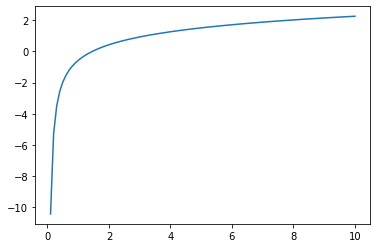

In [505]:
plt.plot(X, Y)

能够发现，digamma函数在正实数域上是单调递增的，并且增速随着X增加而逐步放缓。而根据论文公式推导，最终的互信息MI值可以由如下公式算得：

$$MI(X,Y)=Ψ(k)−<Ψ(n_x+1)+Ψ(n _y+1)>+Ψ(N)$$

转化成更容易理解的代码公式就是：

In [506]:
mi=digamma(n_samples)+np.mean(digamma(k_all))-np.mean(digamma(label_counts))-np.mean(digamma(m_all + 1))
mi

0.36956281121710144

其中每部分的计算都用到的digamma函数，而这里的n_samples、k_all、label_counts和m_all + 1都在正实数域上取值，因此随着这些值的增加digamma也会增加，并且会呈现出一种增速逐渐放缓的增加趋势，其中n_samples是样本总数、k_all是每一组的k近邻个数、label_counts是每一组的元素个数、m_all + 1是整体最近邻个数。由此我们不难得出以下结论：

- 伴随着样本数量增加和最近邻K的增加，互信息也将增加，而伴随着每一组的元素个数增加和整体最近邻（组内最近邻+跨组最近邻）个数增加，互信息将减少。

&emsp;&emsp;但这只是浅层次的结论，这里需要注意的是，在样本总数固定的情况下，离散变量的分类水平越多、每个组的组内样本数量就越少，np.mean(digamma(label_counts))就越小、而MI就会越大，这也就是为何sklearn在互信息法的方法使用注解中说的，互信息法在离散变量与连续变量的筛选过程中，会更加倾向于将分类水平更多的离散变量筛选出来的原因。

- 其二需要注意的是，最近邻K的个数选取也会影响最终的MI计算结果。根据sklearn中的相关寿命，伴随着K的增加，方差将会减少而偏差将增加。这里的方差，指的是相同分组内的元素的整体最近邻个数将趋于一致，而偏差指的是MI指标的判别效力将逐渐下降，这一点从上述MI计算公式中也不难看出。因此K建议就设置为默认值3（后续会介绍），以确保在方差和偏差中保持平衡。

- 其三也是最关键的一点，就是m_all、即整体最近邻个数对MI的影响。这里需要结合np.mean(digamma(k_all))一起来进行观察。MI中计算流程为np.mean(digamma(k_all))-np.mean(digamma(m_all + 1))，很明显k_all是趋于确定的，也就是组内最近邻个数，而m_all表示整体最近邻个数，因此上述计算结果可以粗略理解成跨组最近邻元素个数，很明显，跨组最近邻元素个数越多、组间差异越小、np.mean(digamma(k_all))-np.mean(digamma(m_all + 1))越小、MI值越小，反之亦然。这也是最能体现MI能够衡量组间差异和组内差异的部分，决定MI最终计算结果的核心部分。

&emsp;&emsp;至此，我们就完整理解了离散变量与连续变量之间的MI计算过程。接下来总结离散变量与连续变量之间的MI特征筛选的使用注意事项：

- MI越大、两个变量的关联性就越强；

- 最近邻个数k建议默认选择3，k越大方差越小偏差越大、k越小方差越大偏差越小；

- 对于小样本来说，MI的计算结果会明显受到离散变量取值个数的影响，取值个数越多、MI计算结果也越大，该趋势会在样本数量增加后被削弱，因此小样本仍然建议采用方差分析这一参数方法以保证效果，而在大量样本情况下MI计算效率更高，并且可以同时采用两种方法进行特征筛选，同样也能增加特征筛选结果的丰富性以提升模型融合的效果。

##### 6.3.3 连续变量之间的互信息计算

&emsp;&emsp;接下来继续介绍连续变量之间的互信息计算方法。该方法十分巧妙并且适用面非常广，能够挖掘包括线性关系在内的任意类型关联关系，而用于连续变量之间的特征筛选，也是互信息法应用最广泛的场景。

- 连续变量互信息计算的基本思想

&emsp;&emsp;那么互信息法是如何判断连续变量之间是否存在关联关系的呢？其基本思路并不复杂：假设有x和y是两个连续变量，如果伴随着x变化y不变化，则说明二者无关，反之则说明二者相关，并且可以两两样本进行观察并计算最终累积效应，例如现在有极简数据集如下：

In [507]:
x = np.array([0, 1])
y = np.array([1, 2])
pd.DataFrame({'x':x, 'y':y})

,x,y
0,0,1
1,1,2


其中x和y是两个变量，现总共有两条数据，不难发现，从0号样本到1号样本，x取值增加1、y的取值也增加1，这说明伴随x变化，y也发生了变化，二者或许存在关联性，我们暂时将由这两条样本观察到的关联性记作$α_{01}$。当然，如果样本数量进一步增加，x和y呈现如下数据情况：

In [508]:
x = np.array([0, 1, 2])
y = np.array([1, 2, 1])
pd.DataFrame({'x':x, 'y':y})

,x,y
0,0,1
1,1,2
2,2,1


此时我们再进行两两比较，则会发现从1号样本到2号样本，x变化y也发生了变化（反向变化），因此二者关联性进一步增加，我们暂时将由这两条样本观察到的关联性记作$α_{12}$，但是，如果我们挑选0号样本和2号样本，则会发现伴随着x变化，y并没有发生任何变化，二者并不存在关联性，因此$α_{02}=0$。但整体来看，x和y的关联性应该是由$α_{01}、α_{12}和α_{02}$共同决定，因此整体来看x和y还是存在一定关联性的。

&emsp;&emsp;这也就是连续变量之间的互信息计算的基本思想，不难看出，也正是受该思想的影响，互信息才能有效的识别各种不同类别的变量之间的关联性。但是接下来的问题就是具体数值的指标应该如何计算呢？

- 连续变量的互信息计算过程

&emsp;&emsp;连续变量之间的互信息计算流程非常巧妙，首先仍然是采用了最近邻的计算过程，并且采用了一种名为切比雪夫距离（Chebyshev distance）的计算流程。这里先补充关于切比雪夫距离计算公式：

$$Chebyshe\_distance(P,Q) = \max{(|x_1-x_2|,|y_1-y_2|)}$$

其中$P(x_1,y_1)$和$Q(x_2,y_2)$是二维平面空间中两个不同的点。而从上述公式中也不难看出，切比雪夫距离实际上就是横坐标和纵坐标差值绝对值的最大值。

> 为避免混淆，此处简单回顾欧式距离与曼哈顿距离：     
$$Euclidean\_distance(P,Q) = \sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$$
$$Manhattan\_distance(P,Q) = |x_1-x_2|+|y_1-y_2|$$

现假设有两条样本、数据分布如下：

In [509]:
x = np.array([0, 1])
y = np.array([1, 3])
pd.DataFrame({'x':x, 'y':y})

,x,y
0,0,1
1,1,3


则我们可以将这两条样本视作二维空间内的两个点，x和y分别是两个坐标轴，两点分布如下：

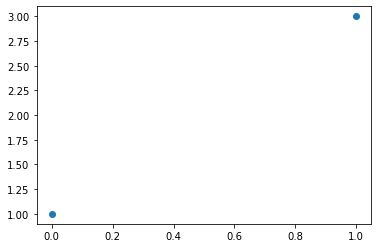

In [510]:
plt.plot(x, y, 'o')

而此时，两个点的切比雪夫距离就是$$\max{(|x_1-x_2|,|y_1-y_2|)}=\max{(|1-0|,|3-1|)}=2$$

也就是纵坐标之间的差值。

&emsp;&emsp;接下来，我们在这个数据集基础上，我们做一个有趣的实验：首先在切比雪夫距离计算下，最近邻为1时范围半径为2，也就是0、1两个样本互为最近邻。然后我们仍然在切比雪夫距离下，以2为半径进行最近邻筛选，当然如果只有0号1号两个样本，仍然是各自能入选对方最近邻。这里进一步进行设想，有没有可能存在这样的一个样本，不是0号样本以（切比雪夫距离等于）2为半径的最近邻，但却是零号样本x维度上以2为半径的最近邻。

&emsp;&emsp;这种样本当然是可能存在的，假设该样本为2号样本$(x_3,y_3)$，由于2号样本是0号样本在x维度上以2为半径的最近邻，因此要满足$x_3 \in[x_1-2,x_1+2]$，即$x_3 \in[-2,2]$，同时2号样本不是0号样本最近邻，因此切比雪夫距离要大于2，也就是y维度上的距离要大于2，即$y_3 \in(-∞,y_1-2)\mathop{\cup}(y_1+2, +∞)$，即$y_3 \in(-∞,-1)\mathop{\cup}(3, +∞)$。也就是说，这样的样本需要在x维度上尽可能接近0号样本、而在y维度上尽可能远离0号样本，而往往这种样本其实就是削弱x和y的关联性的存在，极端情况下例如点(0, 4)、(0, -2)等，此时对比0号样本(0, 1)不难发现，二者伴随x变化y并不会发生变化。

&emsp;&emsp;当然，由于x和y的对称性，如果存在不是0号样本以（切比雪夫距离等于）2为半径的最近邻，但却是零号样本y维度上以2为半径的最近邻的样本，则也能说明x和y的关联性不强，并且这类样本越多、则说明x和y的关联性也就越弱。

&emsp;&emsp;更进一步的，由于距离计算的对称性，因此如果是对于1号样本来说也是类似，在给定的最近邻范围内，无论是x还是y单维度上存在更多的最近邻，都会削弱x和y的关联性。

&emsp;&emsp;综上所述，借助最近邻进行连续变量关联性挖掘的计算流程如下：

&emsp;&emsp;Step 1.根据给定的最近邻个数𝑛_𝑛𝑒𝑖𝑔ℎ𝑏𝑜𝑟𝑠（往往也是3）计算每个样本的切比雪夫半径距离r；

&emsp;&emsp;Step 2.根据半径r，进一步计算每个样本x和y单维度上的最近邻个数，$n_x、n_y$ ;

&emsp;&emsp;Step 3.根据$n_x和n_y$，参照如下公式计算互信息MI：$$MI=(digamma(n\_samples)+digamma(n\_neighbors)-mean(digamma(n_x))-mean(digamma(n_y)))$$

其中𝑛_𝑠𝑎𝑚𝑝𝑙𝑒𝑠是样本总数、𝑑𝑖𝑔𝑎𝑚𝑚𝑎就是此前介绍的伽马函数的对数导函数。从𝑑𝑖𝑔𝑎𝑚𝑚𝑎函数的单调递增性不难发现，伴随$n_x、n_y$的增加，MI也将逐渐减少，而和此前离散变量的互信息计算过程一样，MI越大则两个变量的关联性越明显。不难看出，$n_x、n_y$对变量关联性的影响的量化结果也见于此。

&emsp;&emsp;当然，上述过程的讨论是一半理论推导一半感性理解，详细严谨的数学推导过程详见[《Estimating mutual information》(A. Kraskov, H. Stogbauer and P. Grassberger, Phys. Rev. E 69, 2004)](https://www.researchgate.net/publication/303264392_Grassberger_Estimating_mutual_information)。接下来我们通过参考sklearn中相关计算流程的源码，来查看如何通过代码来执行具体的计算。此处源码函数为_compute_mi_cc，我们复制源码函数为_compute_mi_cc_temp函数如下：

In [511]:
def _compute_mi_cc_temp(x, y, n_neighbors):
    n_samples = x.size

    x = x.reshape((-1, 1))
    y = y.reshape((-1, 1))
    xy = np.hstack((x, y))

    nn = NearestNeighbors(metric="chebyshev", n_neighbors=n_neighbors)

    nn.fit(xy)
    radius = nn.kneighbors()[0]
    radius = np.nextafter(radius[:, -1], 0)

    kd = KDTree(x, metric="chebyshev")
    nx = kd.query_radius(x, radius, count_only=True, return_distance=False)
    nx = np.array(nx) - 1.0

    kd = KDTree(y, metric="chebyshev")
    ny = kd.query_radius(y, radius, count_only=True, return_distance=False)
    ny = np.array(ny) - 1.0

    mi = (
        digamma(n_samples)
        + digamma(n_neighbors)
        - np.mean(digamma(nx + 1))
        - np.mean(digamma(ny + 1))
    )

    return max(0, mi)

在熟悉最近邻的计算过程后，上述代码整体难度并不大，这里重点解释几个关键步骤，首先是双变量的合并所采用的hstack函数：

In [512]:
x = np.array([1, 2, 3])
y = np.array([2, 3, 4])
xy = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
xy

array([[1, 2],
       [2, 3],
       [3, 4]])

然后是我们可以通过在NearestNeighbors评估器中输入metric="chebyshev"来根据切比雪夫距离进行最近邻的计算，更多可以调用的距离计算类函数可以参见sklearn.metrics.DistanceMetric相关说明文档：

In [513]:
NearestNeighbors(metric="chebyshev", n_neighbors=3)

NearestNeighbors(metric='chebyshev', n_neighbors=3)

其三，在使用KDTree进行最近邻元素搜索时，也可以选择切比雪夫距离，只不过此时x是单一维度的变量，切比雪夫距离计算结果就等于欧式距离。

In [514]:
KDTree(x.reshape(-1, 1), metric="chebyshev")

其他计算过程和_compute_mi_cd_temp基本类似。

> 此外，我们可以通过函数命名来区分函数作用，在本部分代码中，c代表连续变量，d代表离散变量，因此cc代表连续变量之间的MI计算，而cd则代表连续变量和离散变量之间的MI计算。

##### 6.3.4 连续变量的互信息计算特性

- 能够挖掘任意关联关系

&emsp;&emsp;接下来，我们继续来看连续变量之间的MI指标的计算特性。首先也是最重要的一点就是，互信息法能够挖掘包括线性关系在内的任意关联关系。我们可以通过如下一组实验来进行验证，首先创建一组完全随机分布的x和y，并计算最终MI值：

In [558]:
n_neighbors = 3

Text(0.5, 1.0, 'MI_0=0.10190')

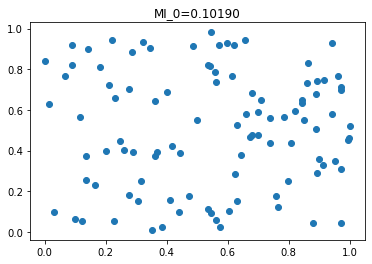

In [559]:
np.random.seed(24)
x0 = np.random.rand(100)
y0 = np.random.rand(100)

plt.plot(x0, y0, 'o')
plt.title('MI_0={:.5f}'.format(_compute_mi_cc_temp(x0, y0, n_neighbors)))

然后在相同样本量情况下创建一组基本满足线性关系、只包含少量扰动项的x1和y1：

Text(0.5, 1.0, 'MI_1=0.83846')

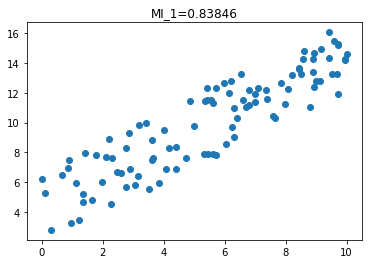

In [517]:
np.random.seed(24)
x1 = np.random.rand(100) * 10
y1 = x1 + 2 + 5 * np.random.rand(100)

plt.plot(x1, y1, 'o')
plt.title('MI_1={:.5f}'.format(_compute_mi_cc_temp(x1, y1, n_neighbors)))

能够发现MI_1明显大于MI_2，表明互信息能够顺利判别线性关系。然后再创建一组非线性关系的x2和y2并计算MI：

Text(0.5, 1.0, 'MI_2=0.43613')

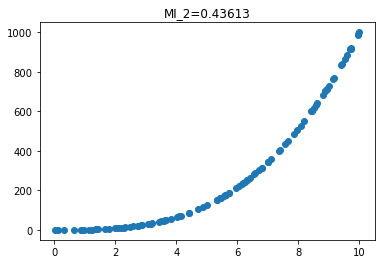

In [518]:
np.random.seed(24)
x2 = np.random.rand(100) * 10
y2 = np.power(x2, 3) + np.random.rand(100)

plt.plot(x2, y2, 'o')
plt.title('MI_2={:.5f}'.format(_compute_mi_cc_temp(x2, y2, n_neighbors)))

能够发现，尽管MI_2值要小于MI_1，但互信息法仍然能够很好的识别非线性关系。接下来创建一组更复杂的非线性关系的x3和y3：

Text(0.5, 1.0, 'MI=0.43438')

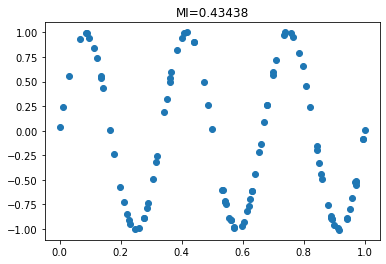

In [519]:
np.random.seed(24)

x3 = np.random.rand(100)
y3 = np.sin(6 * np.pi * x3) + 0.01 * np.random.randn(100)

plt.plot(x3, y3, 'o')
plt.title('MI={:.5f}'.format(_compute_mi_cc_temp(x3, y3, n_neighbors)))

能够发现互信息法仍然能够做出较为准确的识别。综上不难发现，互信息法确实能够判别各种类型的关联关系，就这点而言，相比相关性的F检验，互信息法拥有较大优势。

- 非参数方法的样本数量影响特性

&emsp;&emsp;当然，所有的非参数方法都将极大程度受到样本数量影响，而能够挖掘任意关联关系的连续变量间的互信息计算过程也是如此，并且也是因为能够挖掘任意关联关系，连续变量之间的MI计算结果尤其受到样本数量影响严重。例如我们从上述x3和y3中进行无放回抽样，抽取10个元素：

In [520]:
import random

In [521]:
random.choices?

Signature: random.choices(population, weights=None, *, cum_weights=None, k=1)
Docstring:
Return a k sized list of population elements chosen with replacement.

If the relative weights or cumulative weights are not specified,
the selections are made with equal probability.
File:      d:\anaconda3\lib\random.py
Type:      method


In [522]:
random.seed(21)

xy = np.hstack([x3.reshape(-1, 1), y3.reshape(-1, 1)])

xy_choices = random.choices(xy,k=10)
xy_choices = np.array(xy_choices)
xy_choices

array([[ 0.67180656,  0.09093717],
       [ 0.59689144, -0.97304678],
       [ 0.03143881,  0.55263815],
       [ 0.40925902,  0.99159534],
       [ 0.30601259, -0.48945662],
       [ 0.97012789, -0.51972642],
       [ 0.36281177,  0.53398133],
       [ 0.00202327,  0.03962933],
       [ 0.91666435, -1.00899835],
       [ 0.68023886,  0.26177167]])

Text(0.5, 1.0, 'MI=0.00000')

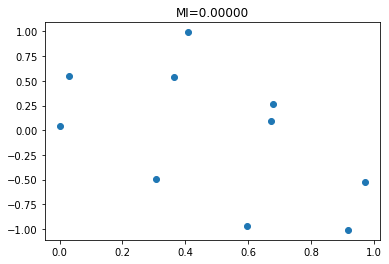

In [523]:
plt.plot(xy_choices[:, 0], xy_choices[:, 1], 'o')
plt.title('MI={:.5f}'.format(_compute_mi_cc_temp(xy_choices[:, 0], xy_choices[:, 1], n_neighbors)))

从抽样结果中我们很难判断x和y是否存在关联性，而最终的MI计算结果也验证了这点。但我们如果从最开始的满足线性关系的x1、y1中进行抽样，结论会略有不同：

Text(0.5, 1.0, 'MI=0.44397')

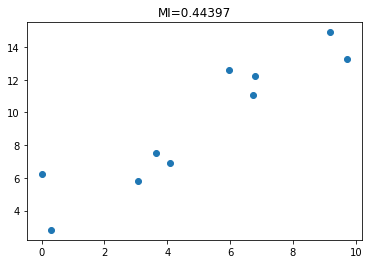

In [524]:
random.seed(21)

xy = np.hstack([x1.reshape(-1, 1), y1.reshape(-1, 1)])

xy_choices = random.choices(xy,k=10)
xy_choices = np.array(xy_choices)

plt.plot(xy_choices[:, 0], xy_choices[:, 1], 'o')
plt.title('MI={:.5f}'.format(_compute_mi_cc_temp(xy_choices[:, 0], xy_choices[:, 1], n_neighbors)))

此时我们发现，尽管只有10个样本，但x和y已经表现出了一定的线性相关性，而最终的MI计算结果也验证了这点。通过对比这次采样结果和上次采样结果我们不难判断，其实线性相关性是一种非常特殊的相关关系，只需要少量样本就能够刻画；而如果是更加复杂的非线性关系，则在样本数量较少时难以体现，此时MI的计算结果也会非常小。这也就是互信息法在作用与连续变量时非参数方法受到样本量影响的具体体现。

&emsp;&emsp;综上所述，如果是需要挖掘线性关系，则样本量大小影响不大，而如果要挖掘非线性关系，需要更大量的样本才能获得更加准确的结果。

#### 6.4 借助互信息法进行特征筛选

##### 6.4.1 互信息评分函数的参数解释

&emsp;&emsp;在了解了互信息的基本原理和计算流程之后，接下来我们来讨论如何借助互信息法来进行特征筛选。需要注意的是，此前介绍的诸多函数（mutual_info_score、_compute_mi_cc和_compute_mi_cd）其实都是底层计算函数，也就是最原始的MI值计算函数，在sklearn中互信息法的实际评分函数为mutual_info_regression和mutual_info_classif，这两个函数是封装在之前那些函数基础之上、更高层同时也是直接面向用户可以调用的函数：

In [525]:
from sklearn.feature_selection import mutual_info_regression,mutual_info_classif

很明显，mutual_info_regression用于回归问题的特征筛选，而mutual_info_classif则用于分类问题的特征筛选。但由于互信息的计算过程较为复杂，因此这些函数的实际使用过程也会更加复杂，两个函数的参数相同，我们以mutual_info_regression为例进行参数解释：

In [526]:
mutual_info_regression?

Signature:
mutual_info_regression(
    X,
    y,
    *,
    discrete_features='auto',
    n_neighbors=3,
    copy=True,
    random_state=None,
)
Docstring:
Estimate mutual information for a continuous target variable.

Mutual information (MI) [1]_ between two random variables is a non-negative
value, which measures the dependency between the variables. It is equal
to zero if and only if two random variables are independent, and higher
values mean higher dependency.

The function relies on nonparametric methods based on entropy estimation
from k-nearest neighbors distances as described in [2]_ and [3]_. Both
methods are based on the idea originally proposed in [4]_.

It can be used for univariate features selection, read more in the
:ref:`User Guide <univariate_feature_selection>`.

Parameters
----------
X : array-like or sparse matrix, shape (n_samples, n_features)
    Feature matrix.

y : array-like of shape (n_samples,)
    Target vector.

discrete_features : {'auto', bool, array-lik

除了必须要输入的x和y之外，还需要人工输入discrete_features、也就是离散变量的列，此处可以输入离散变量列的布尔索引或者列索引，该参数的默认值是auto，在aotu情况下会将所有保存为稀疏矩阵的特征视作离散变量、将其他特征视作连续变量。很明显，基于此前对MI计算过程的了解，离散特征和连续特征的互信息计算过程并不相同，因此该参数需要准确输入才能得到想要的结果。

> 这里有一个可能会引起误解的地方，尽管auto会根据变量类型自动判别是离散变量还是连续变量，但这是针对输入的特征矩阵X整体进行的判别，即X要么是稀疏矩阵而所有的特征都被识别为离散变量、要么X是密集矩阵而所有的特征都被识别为连续变量，而无法在X中部分列设置成稀疏矩阵部分列设置成密集矩阵，函数也无法针对不同列采用不同的方法。

&emsp;&emsp;这里可以简单梳理mutual_info_regression和mutual_info_classif函数分别是调用哪些基础计算函数来进行的计算：

- mutual_info_classif+离散变量：mutual_info_score
- mutual_info_classif+连续变量：_compute_mi_cd
- mutual_info_regression+离散变量：_compute_mi_cd
- mutual_info_regression+连续变量：_compute_mi_cc

具体可参照源码的如下代码部分：

<center><img src="https://tva1.sinaimg.cn/large/e6c9d24ely1h14zf6o8k4j20tp0hjwh5.jpg" alt="image-20220408181230733" style="zoom:50%;" />

也正是因为要调用不同函数进行MI值的计算，所以需要在参数位说明哪些是离散变量，剩下的就是连续变量。这也是sklearn中为数不多的需要区分离散变量和连续变量的情况。

&emsp;&emsp;此外，关于最近邻个数n_neighbors，建议保留默认值3，正如此前所说，随着n_neighbors值增加，将会减少方差但会增加偏差，而n_neighbors值的减少则会提升方差但会降低偏差。同时需要注意的是，mutual_info_regression和mutual_info_classif函数中会随机小幅修改离散变量的值，以确保不存在重复的连续变量值并且和离散变量的MI值保持在同一水平，因此如果是进行带有连续变量的MI计算，结果会有一定的随机性，若要使得结果可重复，则需要设置随机数种子random_state。

##### 6.4.2 借助互信息法进行特征筛选

&emsp;&emsp;接下来我们尝试借助互信息这一指标来进行特征筛选，由于当前数据集是分类标签，因此采用mutual_info_classif评分函数，同时需要注意的是，特征筛选评估器内的评分函数是无法修改默认参数的，因此如果我们要同时计算离散变量和连续变量的MI值，则需要直接采用mutual_info_classif评分函数而非特征筛选评估器进行特征筛选。

- 计算各特征评分

&emsp;&emsp;首先我们带入全部特征，完整执行一次针对各特征的互信息评分。对于原始telco数据集来说，离散变量排布在连续变量之前，因此我们可以按照如下方式创造离散变量的布尔索引：

In [527]:
category_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [528]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [529]:
X_train_OE.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
4067,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,68,79.60,5515.80
3306,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,3,80.00,241.30
3391,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,19.00,73.45
3249,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,10,55.55,551.30
2674,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,4,20.05,91.45


In [530]:
mask = [True]*len(category_cols) + [False]*len(numeric_cols)
mask

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False]

然后带入进行互信息的计算：

In [531]:
mutual_info_classif(X_train_OE, y_train, discrete_features=mask)

array([1.73090078e-04, 9.13473736e-03, 1.29159500e-02, 1.24089586e-02,
       3.11949909e-06, 4.99279481e-04, 5.43286385e-02, 7.08580232e-02,
       4.78061879e-02, 4.70107520e-02, 6.57416875e-02, 3.30813850e-02,
       3.34860937e-02, 9.78731272e-02, 1.81578691e-02, 4.59939447e-02,
       7.08277944e-02, 4.57067323e-02, 4.28992124e-02])

In [532]:
MIC = mutual_info_classif(X_train_OE, y_train, discrete_features=mask, random_state=21)
MIC = pd.Series(MIC, index=category_cols + numeric_cols)
MIC

gender              0.000173
SeniorCitizen       0.009135
Partner             0.012916
Dependents          0.012409
PhoneService        0.000003
MultipleLines       0.000499
InternetService     0.054329
OnlineSecurity      0.070858
OnlineBackup        0.047806
DeviceProtection    0.047011
TechSupport         0.065742
StreamingTV         0.033081
StreamingMovies     0.033486
Contract            0.097873
PaperlessBilling    0.018158
PaymentMethod       0.045994
tenure              0.073132
MonthlyCharges      0.047550
TotalCharges        0.042000
dtype: float64

In [533]:
MIC.sort_values(ascending=False)

Contract            0.097873
tenure              0.073132
OnlineSecurity      0.070858
TechSupport         0.065742
InternetService     0.054329
OnlineBackup        0.047806
MonthlyCharges      0.047550
DeviceProtection    0.047011
PaymentMethod       0.045994
TotalCharges        0.042000
StreamingMovies     0.033486
StreamingTV         0.033081
PaperlessBilling    0.018158
Partner             0.012916
Dependents          0.012409
SeniorCitizen       0.009135
MultipleLines       0.000499
gender              0.000173
PhoneService        0.000003
dtype: float64

能够发现，受到样本不均匀影响，全部特征的互信息数值都偏小，不过仔细观察互信息计算结果不难发现，不同特征的评分还是出现了较为明显的“分层”，例如大多数特征（包括连续变量和离散变量在内）的MI都在小数点后两位，而只有gender、SeniorCitizen、PhoneService等特征的MI值在小数点后三位甚至更小，很明显这些特征和标签的关联性要明显小于其他特征，据此我们就可以对其进行特征筛选。

&emsp;&emsp;当然围绕上述结果，需要注意的是，对于mutual_info_classif和mutual_info_regression函数来说，离散变量是直接使用mutual_info_score进行的计算，而连续变量则进行了一定程度数值调整，最终以保持和离散变量类似的结果水平方便进行横向比较。这也是互信息法易用性的具体表现。

- 以互信息为评分函数的特征筛选器

&emsp;&emsp;与此同时需要注意，因为此处我们修改了mutual_info_classif默认参数，因此已无法使用SelectKBest等评估器进行自动特征筛选了，特征筛选评估器在调用score_func时只能使用默认参数，即把密集矩阵视作连续变量、稀疏矩阵视作离散变量，并且一个X特征矩阵只能有一种类别判定。因此若要调用特征筛选评估器借助MI进行特征筛选，则只能分连续变量和离散变量分别进行筛选。首先是连续变量情况：

In [534]:
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.0716352 , 0.04662425, 0.04380887])

In [535]:
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.07371748, 0.04257017, 0.04368372])

能够发现，多次执行会有略微数值上的差异，但此时我们并不能修改mutual_info_classif的参数，只能在外层设置一个全域的随机数种子，以确保结果是可重复的：

In [536]:
np.random.seed(21)
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.07313173, 0.04755022, 0.04200039])

In [537]:
np.random.seed(21)
KB = SelectKBest(mutual_info_classif, k=2)
KB.fit(X_train_OE[numeric_cols], y_train)
KB.scores_

array([0.07313173, 0.04755022, 0.04200039])

In [538]:
SelectName(KB)

['tenure', 'MonthlyCharges']

In [539]:
KB.get_feature_names_out()

array(['tenure', 'MonthlyCharges'], dtype=object)

此外，如果要对离散变量进行特征筛选，则需要先将离散变量转化为稀疏矩阵。关于稀疏矩阵的详细内容会在后续案例中进行讲解，此处仅作简单介绍。

&emsp;&emsp;稀疏矩阵中的稀疏，并不是一种数学层面对矩阵类型的划分（如正定矩阵、满秩矩阵等），而是数据格式层面对当前矩阵进行的说明。也就是说，对于A矩阵来说，无论是不是稀疏矩阵，实际上都是代表同一组数：

In [540]:
A = pd.DataFrame([[1, 0, 0], [0, 0, 1]])
A

,0,1,2
0,1,0,0
1,0,0,1


In [541]:
A.dtypes

0    int64
1    int64
2    int64
dtype: object

&emsp;&emsp;那为什么还要区分是否是稀疏矩阵呢？其实在特征衍生阶段我们不难发现，很多时候我们都会遇到大量0值的数组，一般情况下数组和矩阵的存储都是不同位置记录不同元素，例如对于上述矩阵A来说，计算机中的存储方式是：$$(0,0)=1（第一行第一列值为1）、(0,1)=0、(0,2)=0... \tag 1$$这种存储方式简洁易懂，但对于大量零值的矩阵、甚至是非零值也全都是1的矩阵来说会比较浪费存储空间（记录的信息太多），对于上述A矩阵，其实还可以按照另外一种形式进行记录，即：$$取值为1的位置有(0,0)、(1,2)，其他所有位置取值为0 \tag 2$$很明显，后者要简单很多、面对大量零值、少量1值的矩阵来说也会非常节省存储空间，当然第二种记录方法也只有在矩阵本身非常稀疏时才能体现存储优势。据此就有了密集矩阵和稀疏矩阵的区分， 即按照第一种方式存储的矩阵就被称为密集矩阵、按照第二种方式存储的矩阵就被称为稀疏矩阵。

> 除了矩阵，向量也可以划分稀疏向量和密集向量；并且除了上述稀疏矩阵的存储方式外，还有非常多种其他存储方法。

> 此外，需要注意稀疏性和稀疏矩阵二者定义的差别。

&emsp;&emsp;而对于稀疏矩阵，有很多创建、转化和本地保存的方法，此处仅介绍如何将密集矩阵转化为稀疏矩阵，其他内容将在后续案例中进行介绍。在pandas中存在一种Spare类型，可以表示稀疏矩阵：

In [542]:
pd.SparseDtype?

Init signature:
pd.SparseDtype(
    dtype: 'Dtype' = <class 'numpy.float64'>,
    fill_value: 'Any' = None,
)
Docstring:     
Dtype for data stored in :class:`SparseArray`.

This dtype implements the pandas ExtensionDtype interface.

Parameters
----------
dtype : str, ExtensionDtype, numpy.dtype, type, default numpy.float64
    The dtype of the underlying array storing the non-fill value values.
fill_value : scalar, optional
    The scalar value not stored in the SparseArray. By default, this
    depends on `dtype`.

    =========== ==========
    dtype       na_value
    =========== ==========
    float       ``np.nan``
    int         ``0``
    bool        ``False``
    datetime64  ``pd.NaT``
    timedelta64 ``pd.NaT``
    =========== ==========

    The default value may be overridden by specifying a `fill_value`.

Attributes
----------
None

Methods
-------
None
File:           d:\anaconda3\lib\site-packages\pandas\core\arrays\sparse\dtype.py
Type:           type
Subclasses:     


In [543]:
int_spar = pd.SparseDtype(int, fill_value=0)

In [544]:
A

,0,1,2
0,1,0,0
1,0,0,1


In [545]:
A = A.astype(int_spar)
A

,0,1,2
0,1,0,0
1,0,0,1


In [546]:
A.dtypes

0    Sparse[int32, 0]
1    Sparse[int32, 0]
2    Sparse[int32, 0]
dtype: object

> pandas中是按照列进行是否是稀疏向量的设置

至此，我们就将矩阵A转化为了稀疏矩阵。接下来我们尝试将原数据集中离散变量转化为稀疏矩阵并带入评估器中进行特征筛选：

In [547]:
X_train_OE[category_cols].head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
4067,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0
3306,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0
3391,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0
3249,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0
2674,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0


In [548]:
X_train_OE[category_cols].dtypes

gender              float64
SeniorCitizen       float64
Partner             float64
Dependents          float64
PhoneService        float64
MultipleLines       float64
InternetService     float64
OnlineSecurity      float64
OnlineBackup        float64
DeviceProtection    float64
TechSupport         float64
StreamingTV         float64
StreamingMovies     float64
Contract            float64
PaperlessBilling    float64
PaymentMethod       float64
dtype: object

In [549]:
category_part = X_train_OE[category_cols].astype(int_spar)
category_part.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
4067,0,0,1,0,1,0,0,2,2,0,2,2,2,2,1,0
3306,0,0,1,1,1,0,1,0,2,0,2,0,0,0,1,2
3391,1,0,0,0,1,0,2,1,1,1,1,1,1,0,0,3
3249,0,0,1,1,1,0,0,0,2,2,0,0,0,0,1,3
2674,0,1,0,0,1,0,2,1,1,1,1,1,1,0,0,3


In [550]:
category_part.dtypes

gender              Sparse[int32, 0]
SeniorCitizen       Sparse[int32, 0]
Partner             Sparse[int32, 0]
Dependents          Sparse[int32, 0]
PhoneService        Sparse[int32, 0]
MultipleLines       Sparse[int32, 0]
InternetService     Sparse[int32, 0]
OnlineSecurity      Sparse[int32, 0]
OnlineBackup        Sparse[int32, 0]
DeviceProtection    Sparse[int32, 0]
TechSupport         Sparse[int32, 0]
StreamingTV         Sparse[int32, 0]
StreamingMovies     Sparse[int32, 0]
Contract            Sparse[int32, 0]
PaperlessBilling    Sparse[int32, 0]
PaymentMethod       Sparse[int32, 0]
dtype: object

In [551]:
KB = SelectKBest(mutual_info_classif, k=10)
KB.fit(category_part, y_train)
KB.scores_

array([1.73090078e-04, 9.13473736e-03, 1.29159500e-02, 1.24089586e-02,
       3.11949909e-06, 4.99279481e-04, 5.43286385e-02, 7.08580232e-02,
       4.78061879e-02, 4.70107520e-02, 6.57416875e-02, 3.30813850e-02,
       3.34860937e-02, 9.78731272e-02, 1.81578691e-02, 4.59939447e-02])

也得到了类似的评分结果。这里需要注意，我们不能将稀疏矩阵和密集矩阵拼接到一起然后带入进行特征筛选，mutual_info_classif无法在一个X中区分连续变量还是离散变量，最终都会将其视作连续变量（也就是密集矩阵），而最终输出结果也将是极度不准确的：

In [552]:
X_train_OE_spar = pd.concat([category_part, X_train_OE[numeric_cols]], axis=1)

In [553]:
X_train_OE_spar.dtypes

gender              Sparse[int32, 0]
SeniorCitizen       Sparse[int32, 0]
Partner             Sparse[int32, 0]
Dependents          Sparse[int32, 0]
PhoneService        Sparse[int32, 0]
MultipleLines       Sparse[int32, 0]
InternetService     Sparse[int32, 0]
OnlineSecurity      Sparse[int32, 0]
OnlineBackup        Sparse[int32, 0]
DeviceProtection    Sparse[int32, 0]
TechSupport         Sparse[int32, 0]
StreamingTV         Sparse[int32, 0]
StreamingMovies     Sparse[int32, 0]
Contract            Sparse[int32, 0]
PaperlessBilling    Sparse[int32, 0]
PaymentMethod       Sparse[int32, 0]
tenure                         int64
MonthlyCharges               float64
TotalCharges                 float64
dtype: object

In [554]:
KB = SelectKBest(mutual_info_classif, k=10)
KB.fit(X_train_OE_spar, y_train)
KB.scores_

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0.01258467, 0.00622113, 0.01795915, 0.00999533, 0.        ,
       0.        , 0.04713925, 0.07712814, 0.04608793, 0.05024197,
       0.06922447, 0.02616885, 0.03397653, 0.10177979, 0.01922933,
       0.04941821, 0.07751313, 0.05026959, 0.04433634])

In [555]:
KB = SelectKBest(mutual_info_classif, k=10)
KB.fit(X_train_OE_spar, y_train)
KB.scores_

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0.        , 0.01491473, 0.00680964, 0.00386814, 0.00338383,
       0.        , 0.05816477, 0.06796908, 0.05277894, 0.04531854,
       0.06085727, 0.02753767, 0.03438466, 0.1061525 , 0.01747497,
       0.03970667, 0.07175468, 0.05023533, 0.04330436])

这也是sklearn说明文档中反复强调禁止的操作。

&emsp;&emsp;最后需要注意的是，如果是针对分类问题对离散变量进行特征筛选，则还可以选择normalized_mutual_info_score和adjusted_mutual_info_score两个指标，两个指标都是对mutual_info_score进行的修正，二者都是借助分类变量的信息熵构建了F统计量，并借助这个F统计量对原始mutual_info_score过程进行修改，normalized_mutual_info_score能够将最终的评分放缩到0-1范围内，从而进一步方便进行数值层面上的比较，而adjusted_mutual_info_score则是修正了分类变量的类别数越大、MI值越高的问题，使得最终能够更好的比较不同分类水平下的离散变量的关联性。

In [560]:
from sklearn.metrics import normalized_mutual_info_score,adjusted_mutual_info_score

In [561]:
NMI = pd.Series(0, index=category_cols)

for col in category_cols:
    NMI[col] = normalized_mutual_info_score(X_train_OE[col], y_train)

NMI

gender              0.000273
SeniorCitizen       0.018070
Partner             0.020389
Dependents          0.020912
PhoneService        0.000007
MultipleLines       0.000657
InternetService     0.066543
OnlineSecurity      0.088089
OnlineBackup        0.058660
DeviceProtection    0.057629
TechSupport         0.081629
StreamingTV         0.040404
StreamingMovies     0.040897
Contract            0.124614
PaperlessBilling    0.029033
PaymentMethod       0.047419
dtype: float64

In [562]:
NMI['gender']

0.0002730741488599909

In [563]:
AMI = pd.Series(0, index=category_cols)

for col in category_cols:
    AMI[col] = adjusted_mutual_info_score(X_train_OE[col], y_train)

AMI

gender              0.000124
SeniorCitizen       0.017886
Partner             0.020243
Dependents          0.020756
PhoneService       -0.000204
MultipleLines       0.000408
InternetService     0.066326
OnlineSecurity      0.087874
OnlineBackup        0.058442
DeviceProtection    0.057410
TechSupport         0.081413
StreamingTV         0.040182
StreamingMovies     0.040675
Contract            0.124402
PaperlessBilling    0.028886
PaymentMethod       0.047140
dtype: float64

&emsp;&emsp;至此，我们就完整介绍了不带入模型情况下所有的特征筛选方法。